In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException,StaleElementReferenceException #except문 처리
import requests
import re
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import datetime
from openpyxl import Workbook
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import os

포트폴리오 스토리텔링: "저는 데이터 뒤에 숨은 사람을 봅니다."
이 분석 결과를 바탕으로, 서영님은 포트폴리오에 이런 강력한 스토리를 담을 수 있습니다.
문제 제기: "단순히 긍정/부정 단어의 개수를 세는 것만으로는 고객의 진짜 만족도를 알 수 없습니다. 특히, '보통이에요' 와 같은 중립적인 단어에 숨겨진 진짜 불만을 어떻게 찾아낼 수 있을까요?"
해결 과정: "이 문제를 해결하기 위해, 저는 13,000개가 넘는 리뷰 텍스트의 문맥을 학습한 KoELECTRA 모델을 파인튜닝했습니다. 그 결과, 제 모델은 '보통', '그냥저냥'과 같은 단답형 리뷰가 실제로는 가장 강한 부정 신호임을 학습하고 성공적으로 분류해냈습니다."
핵심 인사이트: "또한, 부정 리뷰가 가장 많이 발생한 곳은 의외로 맛이 보장된 대형 프랜차이즈들이었습니다. 이들의 부정 리뷰를 심층 분석한 결과, 고객들의 불만은 '맛'이 아닌 **'서비스', '운영', '환경'**과 같은 비음식적 요인에 집중되어 있음을 발견했습니다. 이는 프랜차이즈 매장 관리의 중요성을 시사하는 중요한 포인트입니다."
기대 효과: "따라서 제가 개발한 이 분석 시스템을 활용하면, 식당 주인들은 이전에는 놓치고 있던 '침묵의 불만' 고객을 찾아내고, 맛 외에 어떤 부분을 개선해야 할지에 대한 구체적이고 실행 가능한 데이터를 얻을 수 있습니다."

### 가천대 맛집 링크 크롤링

In [9]:

# 2. 웹 드라이버 설정 및 목표 페이지 이동
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)
url = "https://map.naver.com/p/search/가천대 맛집"
driver.get(url)

print("페이지 로딩 중... 5초 대기")
time.sleep(5)

try:
    # --- STEP 1: '목록' 프레임으로 진입 ---
    driver.switch_to.frame("searchIframe")
    print("1. 'searchIframe'으로 진입 성공!")
    time.sleep(1)

    # --- STEP 2: 첫 번째 식당 클릭 (상세 정보 로드를 위해) ---
    # 먼저 식당 목록 중 첫 번째를 클릭해서 상세 정보 창을 활성화해야 '공유' 버튼이 나타납니다.
    first_restaurant_in_list = driver.find_elements(By.CSS_SELECTOR, "li.UEzoS")[0]
    restaurant_name = first_restaurant_in_list.find_element(By.CSS_SELECTOR, "span.TYaxT").text
    first_restaurant_in_list.find_element(By.CSS_SELECTOR, "a.place_bluelink").click()
    print(f"2. '{restaurant_name}'을 클릭하여 상세 정보 창 활성화.")
    time.sleep(3) # 상세 정보 로딩 대기

    # --- STEP 3: '상세 정보' 프레임으로 진입 ---
    driver.switch_to.default_content() # 바깥 세상으로 나왔다가
    driver.switch_to.frame("entryIframe") # 상세 정보 프레임으로 들어감
    print("3. 'entryIframe'으로 진입 성공!")

    # --- STEP 4: 상세 정보 프레임 안의 '공유' 버튼 클릭 ---
    # 서영님이 찾아주신 ID를 사용해서 공유 버튼을 정확히 찾습니다.
    share_button = driver.find_element(By.ID, "_btp.share")
    share_button.click()
    print("4. 공유 버튼 클릭 성공!")
    
    # --- STEP 5: 공유 팝업창에서 '링크' 가져오기 ---
    # 팝업창은 별도의 iframe이 아닐 확률이 높습니다. 바로 요소를 찾습니다.
    # WebDriverWait을 사용해서 요소가 나타날 때까지 기다리는 것이 안정적입니다.
    wait = WebDriverWait(driver, 10)
    link_element = wait.until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "a._spi_input_copyurl"))
    )
    shared_link = link_element.get_attribute('href')
    
    print(f"\n🎉 성공! '{restaurant_name}'의 공유 링크를 수집했습니다.")
    print(f"링크: {shared_link}")

except Exception as e:
    print(f"\n😥 오류가 발생했습니다: {e}")
    # ... (오류 메시지) ...

finally:
    time.sleep(10)
    driver.quit()

페이지 로딩 중... 5초 대기
1. 'searchIframe'으로 진입 성공!
2. '통큰곱창 성남본점'을 클릭하여 상세 정보 창 활성화.
3. 'entryIframe'으로 진입 성공!
4. 공유 버튼 클릭 성공!

🎉 성공! '통큰곱창 성남본점'의 공유 링크를 수집했습니다.
링크: https://naver.me/FxFtIa62


In [15]:
# 스크롤 내려서 식당 링크 가져오기 코드 !!


# -----------------------------------------------------------------
# PART 1: 크롤러 초기 설정 (브라우저 켜기, 페이지 이동)
# -----------------------------------------------------------------
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)
driver.maximize_window()
url = "https://map.naver.com/p/search/가천대 맛집"
driver.get(url)
print("페이지 로딩 중... 5초 대기")
time.sleep(5)

collected_links = []

try:
    driver.switch_to.frame("searchIframe")
    
    # -----------------------------------------------------------------
    # PART 2: 모든 페이지를 순회하는 루프 시작
    # -----------------------------------------------------------------
    page_count = 1
    while True: 
        print(f"\n--- {page_count} 페이지 크롤링 시작 ---")
        
        # --- ✨✨✨ 핵심 수정: 정확한 스크롤 영역 지정 ✨✨✨ ---
        try:
            # 1. id를 사용해 정확한 스크롤 영역을 찾습니다.
            scroll_area = driver.find_element(By.ID, "_pcmap_list_scroll_container")
            
            last_count = 0
            print("지능형 스크롤 시작...")
            while True:
                # 2. JavaScript를 사용해 'scroll_area'의 스크롤을 맨 아래로 내립니다.
                driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scroll_area)
                time.sleep(1.5) # 데이터 로딩을 위한 충분한 대기 시간
                
                new_count = len(driver.find_elements(By.CSS_SELECTOR, "li.UEzoS"))
                
                if new_count == last_count:
                    print(f"모든 식당({new_count}개)을 로딩했습니다.")
                    break
                last_count = new_count
        except Exception as e:
            print(f"스크롤 영역을 찾는 데 실패했습니다: {e}")

        # -----------------------------------------------------------

        restaurants_list = driver.find_elements(By.CSS_SELECTOR, "li.UEzoS")
        num_restaurants = len(restaurants_list)
        print(f"현재 페이지에서 {num_restaurants}개의 식당을 찾았습니다. 링크 수집을 시작합니다.")

        # -----------------------------------------------------------------
        # PART 3: 한 페이지 내의 모든 식당을 순회하는 루프
        # -----------------------------------------------------------------
        for i in range(num_restaurants):
            current_restaurant = driver.find_elements(By.CSS_SELECTOR, "li.UEzoS")[i]
            restaurant_name = "이름 모를 식당"
            
            try:
                restaurant_name = current_restaurant.find_element(By.CSS_SELECTOR, "span.TYaxT").text
                current_restaurant.find_element(By.CSS_SELECTOR, "a.place_bluelink").click()
                time.sleep(2)

                driver.switch_to.default_content()
                driver.switch_to.frame("entryIframe")

                wait = WebDriverWait(driver, 10)
                share_button = wait.until(EC.element_to_be_clickable((By.ID, "_btp.share")))
                share_button.click()
                
                link_element = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "a._spi_input_copyurl")))
                shared_link = link_element.get_attribute('href')
                
                print(f"  - {restaurant_name}: {shared_link}")
                collected_links.append({'name': restaurant_name, 'url': shared_link})
                
                # 팝업 닫기는 자동으로 된다고 가정하고 코드를 제거
                
            except Exception as e:
                print(f"  - '{restaurant_name}' 처리 중 오류 발생!")
                # traceback.print_exc() # 필요 시 주석 해제

            finally:
                # 다음 식당을 위해 목록 프레임으로 복귀
                driver.switch_to.default_content()
                driver.switch_to.frame("searchIframe")
                time.sleep(1)
        
        # -----------------------------------------------------------------
        # PART 4: 다음 페이지로 이동
        # -----------------------------------------------------------------
        try:
            next_button = driver.find_element(By.CSS_SELECTOR, "a.eUTV2:not([aria-disabled='true'])")
            next_button.click()
            page_count += 1
            time.sleep(3)
        except Exception:
            print("\n마지막 페이지입니다. 링크 수집을 종료합니다.")
            break

except Exception as e:
    print(f"크롤링 전체 과정에서 예기치 못한 심각한 오류가 발생했습니다.")
    traceback.print_exc()

finally:
    # -----------------------------------------------------------------
    # PART 5: 모든 작업 완료 후 정리
    # -----------------------------------------------------------------
    driver.quit()
    df = pd.DataFrame(collected_links)
    now = time.strftime('%Y%m%d_%H%M%S')
    filename = f"gachon_restaurant_links_{now}.csv"
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"\n====== 최종 완료: 총 {len(collected_links)}개의 링크를 수집하여 '{filename}'에 저장했습니다. ======")

페이지 로딩 중... 5초 대기

--- 1 페이지 크롤링 시작 ---
지능형 스크롤 시작...
모든 식당(49개)을 로딩했습니다.
현재 페이지에서 49개의 식당을 찾았습니다. 링크 수집을 시작합니다.
  - 회스시: https://naver.me/5sseMIa6
  - 인생극장쪽갈비 성남점: https://naver.me/xtgpbuVd
  - 화리화리 성남가천대점: https://naver.me/xq3a3F04
  - 화로상회 성남복정점: https://naver.me/GPdoVFlD
  - 하노이쌀국수: https://naver.me/GSDAjujH
  - 원조 태평동 곱창: https://naver.me/5Q375D6c
  - 도미노피자 성남태평점: https://naver.me/GtU3Z3KU
  - 무화과나무아래: https://naver.me/Gj6V6y0d
  - 육연차: https://naver.me/GsjpVpWP
  - 스타벅스 가천대학교점: https://naver.me/GFBhFS95
  - '복정로10술집' 처리 중 오류 발생!
  - 카페 1988: https://naver.me/GyYbAMB5
  - 고기하나 신흥점: https://naver.me/GBFzl2ap
  - 바다왕국아구찜&해물찜 성남점: https://naver.me/FdCxRwFC
  - 고기로 한끼: https://naver.me/xJiOm0zz
  - 메가MGC커피 가천대역점: https://naver.me/xPUU9OmF
  - BHC치킨 태평역점: https://naver.me/56RxLUxQ
  - 원조왕십리곱창: https://naver.me/GyYbP9ue
  - 배스킨라빈스 가천대역: https://naver.me/F88p9LGS
  - 치미치미: https://naver.me/FEUszJ1l
  - 공차 가천대점: https://naver.me/GzENdgEg
  - 파스쿠찌 가천대점: https://naver.me/FjbWqdCQ
  - 포크포크: 

Traceback (most recent call last):
  File "/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_6140/1281276211.py", line 76, in <module>
    time.sleep(2)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py", line 536, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/urllib3/connection.py", line 507, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/http/client.py", line 1428, in getresponse
    response.begin()
  File "/opt/anaconda3/lib/python3.12/http/client.py", line 331, in begin
  

In [21]:

    
    print(f"\n====== 중복 제거 전, 총 {len(collected_links)}개의 링크를 수집했습니다. ======")
    
    # 1. 수집된 데이터를 pandas DataFrame으로 변환
    df = pd.DataFrame(collected_links)
    
    # 2. 'url' 컬럼을 기준으로 중복된 행을 제거합니다.
    #    keep='first'는 중복된 것들 중 첫 번째 것만 남기라는 의미입니다.
    df_no_duplicates = df.drop_duplicates(subset=['url'], keep='first')
    
    print(f"====== 중복 제거 후, 총 {len(df_no_duplicates)}개의 고유한 링크를 남겼습니다. ======")
    
    # 3. 중복이 제거된 깨끗한 데이터를 CSV 파일로 저장
    now = time.strftime('%Y%m%d_%H%M%S')
    filename = f"gachon_restaurant_links_unique_{now}.csv"
    df_no_duplicates.to_csv(filename, index=False, encoding='utf-8-sig')
    
    print(f"\n====== 최종 완료: 고유 링크를 '{filename}'에 저장했습니다. ======")


====== 중복 제거 전, 총 164개의 링크를 수집했습니다. ======
====== 중복 제거 후, 총 117개의 고유한 링크를 남겼습니다. ======

====== 최종 완료: 고유 링크를 'gachon_restaurant_links_unique_20250908_213318.csv'에 저장했습니다. ======


### 식당 고유 번호 가져와서 다시 링크에 붙이기....

In [11]:
### 찐찐찐찐 코드 !!!!
# -----------------------------------------------------------------
# PART 0: 필요한 모든 도구(라이브러리)를 맨 위에 불러옵니다.
# -----------------------------------------------------------------
import time
import pandas as pd
import traceback
import re # 숫자만 추출하기 위해 re 라이브러리 추가

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# -----------------------------------------------------------------
# PART 1: 모든 상세 정보를 수집하는 로봇(함수) 정의
# -----------------------------------------------------------------
def scrape_reviews_from_id(restaurant_name, restaurant_id, driver):
    reviews_data = []
    review_url = f"https://m.place.naver.com/restaurant/{restaurant_id}/review/visitor"
    
    try:
        driver.get(review_url)
        print(f"  - 리뷰 페이지로 직접 이동: {review_url}")
        time.sleep(3)

        print("  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...")
        while True:
            try:
                driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
                time.sleep(1.5)
                more_reviews_button = driver.find_element(By.XPATH, "//span[contains(text(), '펼쳐서 더보기')]")
                more_reviews_button.click()
                time.sleep(1.5)
            except Exception:
                print("  - 모든 리뷰를 펼쳤습니다.")
                break
        
        print("  - 최종 리뷰 및 상세 정보 수집을 시작합니다...")
        try:
            review_elements = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "li.EjjAW"))
            )
        except:
            print("  - 기본 셀렉터(li.EjjAW)로 리뷰를 못 찾음 → fallback 시도")
            try:
                review_elements = WebDriverWait(driver, 10).until(
                    EC.presence_of_all_elements_located((By.CSS_SELECTOR, "ul > li"))
                )
            except:
                print(f"  - '{restaurant_name}' 리뷰 요소를 끝내 찾지 못했습니다. (리뷰 없음 가능)")
                return []

        if not review_elements:
            print(f"  - '{restaurant_name}' 리뷰가 없습니다.")
            return []

        # 각 리뷰 요소 순회
        for review in review_elements:
            try:
                nickname = ''
                content = ''
                date = ''
                revisit_count = '1'
                reviewer_review_count = '0'
                reviewer_photo_count = '0'

                # 닉네임
                try:
                    nickname = review.find_element(By.CSS_SELECTOR, "span.pui__uslU0d").text.strip()
                except:
                    pass
                
                # 리뷰 텍스트
                try:
                    content = review.find_element(By.CSS_SELECTOR, "a[data-pui-click-code='rvshowmore']").text.strip()
                except:
                    pass
                
                # 작성일
                try:
                    date = review.find_element(By.TAG_NAME, "time").text.strip()
                except:
                    pass

                # 재방문 횟수
                info_spans = review.find_elements(By.CSS_SELECTOR, "span.pui__gfuUIT")
                for span in info_spans:
                    if '번째 방문' in span.text:
                        revisit_count = re.search(r'\d+', span.text).group()
                        break

                # 리뷰어 정보
                reviewer_info_spans = review.find_elements(By.CSS_SELECTOR, "span.pui__WN-kAf")
                for span in reviewer_info_spans:
                    if '리뷰' in span.text:
                        reviewer_review_count = re.search(r'\d+', span.text).group()
                    elif '사진' in span.text:
                        reviewer_photo_count = re.search(r'\d+', span.text).group()

                if content:
                    reviews_data.append([
                        restaurant_name, nickname, content, date, revisit_count, 
                        reviewer_review_count, reviewer_photo_count
                    ])
            except:
                continue

    except Exception as e:
        print(f"  - '{restaurant_name}' 리뷰 수집 중 오류 발생!")
        traceback.print_exc()

    print(f"  - '{restaurant_name}'에서 {len(reviews_data)}개의 리뷰 수집 완료.")
    return reviews_data


# -----------------------------------------------------------------
# PART 2: 메인 실행 부분 (파일 이름만 꼭 확인해주세요!)
# -----------------------------------------------------------------
if __name__ == "__main__":
    
    # (중요!) 여기에 ID가 포함된 CSV 파일의 정확한 이름을 넣어주세요.
    INPUT_CSV_FILE = "gachon_links_with_ids.csv"
    try:
        links_df = pd.read_csv(INPUT_CSV_FILE)
        links_df.dropna(subset=['restaurant_id'], inplace=True)
        links_df['restaurant_id'] = links_df['restaurant_id'].astype(int).astype(str)
        target_restaurants = links_df.to_dict('records')
    except FileNotFoundError:
        print(f"오류: '{INPUT_CSV_FILE}' 파일을 찾을 수 없습니다. 파일 이름을 확인해주세요.")
        exit()

    all_reviews_data = []
    
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.maximize_window()

    print(f"총 {len(target_restaurants)}개의 식당에 대한 리뷰 수집을 시작합니다.")

    try:
        for i, restaurant in enumerate(target_restaurants):
            name = restaurant['name']
            res_id = restaurant['restaurant_id'] 
            
            print(f"\n--- [{i+1}/{len(target_restaurants)}] '{name}' (ID: {res_id}) 리뷰 수집 시작 ---")
            
            reviews = scrape_reviews_from_id(name, res_id, driver)
            all_reviews_data.extend(reviews)
            time.sleep(2)

    except Exception as e:
        print(f"전체 크롤링 과정에서 예기치 못한 오류가 발생했습니다.")
        traceback.print_exc()
        
    finally:
        driver.quit()
        now = time.strftime('%Y%m%d_%H%M%S')
        filename = f"gachon_total_reviews_with_full_details_{now}.csv"
        
        # DataFrame 생성 시 컬럼 이름을 추가된 데이터에 맞게 수정합니다.
        result_df = pd.DataFrame(all_reviews_data, columns=[
            'Restaurant', 'Nickname', 'Review', 'Date', 
            'Revisit_Count', 'Reviewer_Review_Count', 'Reviewer_Photo_Count'
        ])
        result_df.to_csv(filename, index=False, encoding='utf-8-sig')
        
        print(f"\n====== 최종 완료: 총 {len(all_reviews_data)}개의 상세 리뷰를 수집하여 '{filename}'에 저장했습니다. ======")

총 117개의 식당에 대한 리뷰 수집을 시작합니다.

--- [1/117] '회스시' (ID: 1920797605) 리뷰 수집 시작 ---
  - 리뷰 페이지로 직접 이동: https://m.place.naver.com/restaurant/1920797605/review/visitor
  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...
  - 모든 리뷰를 펼쳤습니다.
  - 최종 리뷰 및 상세 정보 수집을 시작합니다...
  - '회스시'에서 505개의 리뷰 수집 완료.

--- [2/117] '인생극장쪽갈비 성남점' (ID: 20536482) 리뷰 수집 시작 ---
  - 리뷰 페이지로 직접 이동: https://m.place.naver.com/restaurant/20536482/review/visitor
  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...
  - 모든 리뷰를 펼쳤습니다.
  - 최종 리뷰 및 상세 정보 수집을 시작합니다...
  - '인생극장쪽갈비 성남점'에서 0개의 리뷰 수집 완료.

--- [3/117] '화리화리 성남가천대점' (ID: 1118109582) 리뷰 수집 시작 ---
  - 리뷰 페이지로 직접 이동: https://m.place.naver.com/restaurant/1118109582/review/visitor
  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...

====== 최종 완료: 총 505개의 상세 리뷰를 수집하여 'gachon_total_reviews_with_full_details_20250909_093403.csv'에 저장했습니다. ======


KeyboardInterrupt: 

In [13]:
# -----------------------------------------------------------------
# PART 0: 필요한 모든 도구(라이브러리)를 맨 위에 불러옵니다.
# -----------------------------------------------------------------
import time
import pandas as pd
import traceback
import re

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# -----------------------------------------------------------------
# PART 1: 모든 상세 정보를 수집하는 로봇(함수) 정의
# -----------------------------------------------------------------
def scrape_reviews_from_id(restaurant_name, restaurant_id, driver):
    reviews_data = []
    review_url = f"https://m.place.naver.com/restaurant/{restaurant_id}/review/visitor"
    
    try:
        driver.get(review_url)
        print(f"  - 리뷰 페이지로 직접 이동: {review_url}")
        time.sleep(3)

        print("  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...")
        while True:
            try:
                driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
                time.sleep(1.5)
                more_reviews_button = driver.find_element(By.XPATH, "//span[contains(text(), '펼쳐서 더보기')]")
                driver.execute_script("arguments[0].click();", more_reviews_button)
                time.sleep(1.5)
            except Exception:
                print("  - 모든 리뷰를 펼쳤습니다.")
                break
        
        print("  - 모든 리뷰가 화면에 그려지기를 기다립니다 (3초)...")
        time.sleep(3)

        print("  - 최종 리뷰 및 상세 정보 수집을 시작합니다...")
        review_elements = driver.find_elements(By.CSS_SELECTOR, "li.EjjAW")

        for review in review_elements:
            try:
                nickname = review.find_element(By.CSS_SELECTOR, "span.pui__uslU0d").text.strip()
                
                # --- ✨✨✨ 여기가 최종 수정된 핵심 부분! ✨✨✨ ---
                # 긴 리뷰, 짧은 리뷰 모두 포함하는 부모 div 컨테이너의 텍스트를 가져옵니다.
                content = review.find_element(By.CSS_SELECTOR, "div.pui__vn15t2").text.strip()
                # --------------------------------------------------
                
                date = ''
                revisit_count = '1'
                reviewer_review_count = '0'
                reviewer_photo_count = '0'

                try:
                    date = review.find_element(By.TAG_NAME, "time").text.strip()
                except: pass
                
                info_spans = review.find_elements(By.CSS_SELECTOR, "span.pui__gfuUIT")
                for span in info_spans:
                    if '번째 방문' in span.text:
                        revisit_count = re.search(r'\d+', span.text).group()
                        break
                
                reviewer_info_spans = review.find_elements(By.CSS_SELECTOR, "span.pui__WN-kAf")
                for span in reviewer_info_spans:
                    if '리뷰' in span.text:
                        reviewer_review_count = re.search(r'\d+', span.text).group()
                    elif '사진' in span.text:
                        reviewer_photo_count = re.search(r'\d+', span.text).group()

                if content:
                    reviews_data.append([
                        restaurant_name, nickname, content, date, revisit_count, 
                        reviewer_review_count, reviewer_photo_count
                    ])
            except Exception:
                continue

    except Exception as e:
        print(f"  - '{restaurant_name}' 리뷰 수집 중 오류 발생!")
        traceback.print_exc()

    print(f"  - '{restaurant_name}'에서 {len(reviews_data)}개의 리뷰 수집 완료.")
    return reviews_data

# -----------------------------------------------------------------
# PART 2: 메인 실행 부분 (파일 이름만 꼭 확인해주세요!)
# -----------------------------------------------------------------
if __name__ == "__main__":
    
    # (중요!) 여기에 ID가 포함된 CSV 파일의 정확한 이름을 넣어주세요.
    INPUT_CSV_FILE = "gachon_links_with_ids.csv"
    try:
        links_df = pd.read_csv(INPUT_CSV_FILE)
        links_df.dropna(subset=['restaurant_id'], inplace=True)
        links_df['restaurant_id'] = links_df['restaurant_id'].astype(int).astype(str)
        target_restaurants = links_df.to_dict('records')
    except FileNotFoundError:
        print(f"오류: '{INPUT_CSV_FILE}' 파일을 찾을 수 없습니다. 파일 이름을 확인해주세요.")
        exit()

    all_reviews_data = []
    
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.maximize_window()

    print(f"총 {len(target_restaurants)}개의 식당에 대한 리뷰 수집을 시작합니다.")

    try:
        for i, restaurant in enumerate(target_restaurants):
            name = restaurant['name']
            res_id = restaurant['restaurant_id'] 
            
            print(f"\n--- [{i+1}/{len(target_restaurants)}] '{name}' (ID: {res_id}) 리뷰 수집 시작 ---")
            
            reviews = scrape_reviews_from_id(name, res_id, driver)
            all_reviews_data.extend(reviews)
            time.sleep(2)

    except Exception as e:
        print(f"전체 크롤링 과정에서 예기치 못한 오류가 발생했습니다.")
        traceback.print_exc()
        
    finally:
        driver.quit()
        now = time.strftime('%Y%m%d_%H%M%S')
        filename = f"gachon_total_reviews_with_full_details_{now}.csv"
        
        result_df = pd.DataFrame(all_reviews_data, columns=[
            'Restaurant', 'Nickname', 'Review', 'Date', 
            'Revisit_Count', 'Reviewer_Review_Count', 'Reviewer_Photo_Count'
        ])
        result_df.to_csv(filename, index=False, encoding='utf-8-sig')
        
        print(f"\n====== 최종 완료: 총 {len(all_reviews_data)}개의 상세 리뷰를 수집하여 '{filename}'에 저장했습니다. ======")

총 117개의 식당에 대한 리뷰 수집을 시작합니다.

--- [1/117] '회스시' (ID: 1920797605) 리뷰 수집 시작 ---
  - 리뷰 페이지로 직접 이동: https://m.place.naver.com/restaurant/1920797605/review/visitor
  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...
  - 모든 리뷰를 펼쳤습니다.
  - 모든 리뷰가 화면에 그려지기를 기다립니다 (3초)...
  - 최종 리뷰 및 상세 정보 수집을 시작합니다...
  - '회스시'에서 505개의 리뷰 수집 완료.

--- [2/117] '인생극장쪽갈비 성남점' (ID: 20536482) 리뷰 수집 시작 ---
  - 리뷰 페이지로 직접 이동: https://m.place.naver.com/restaurant/20536482/review/visitor
  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...
  - 모든 리뷰를 펼쳤습니다.
  - 모든 리뷰가 화면에 그려지기를 기다립니다 (3초)...
  - 최종 리뷰 및 상세 정보 수집을 시작합니다...
  - '인생극장쪽갈비 성남점'에서 1222개의 리뷰 수집 완료.

--- [3/117] '화리화리 성남가천대점' (ID: 1118109582) 리뷰 수집 시작 ---
  - 리뷰 페이지로 직접 이동: https://m.place.naver.com/restaurant/1118109582/review/visitor
  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...
  - 모든 리뷰를 펼쳤습니다.
  - 모든 리뷰가 화면에 그려지기를 기다립니다 (3초)...
  - 최종 리뷰 및 상세 정보 수집을 시작합니다...
  - '화리화리 성남가천대점'에서 1263개의 리뷰 수집 완료.

--- [4/117] '화로상회 성남복정점' (ID: 1375449177) 리뷰 수집 시작 ---
  - 리뷰 페이지로 직접 이동: https://m.place.nave

KeyboardInterrupt: 

In [23]:
### 이어서 하는 코드 


# -----------------------------------------------------------------
# PART 0: 필요한 모든 도구(라이브러리)를 맨 위에 불러옵니다.
# -----------------------------------------------------------------
import time
import pandas as pd
import traceback
import re
import os # 파일 존재 여부를 확인하기 위해 os 라이브러리 추가

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# -----------------------------------------------------------------
# PART 1: 모든 상세 정보를 수집하는 로봇(함수) 정의 (이전과 동일)
# -----------------------------------------------------------------
def scrape_reviews_from_id(restaurant_name, restaurant_id, driver):
    reviews_data = []
    review_url = f"https://m.place.naver.com/restaurant/{restaurant_id}/review/visitor"
    
    try:
        driver.get(review_url)
        print(f"  - 리뷰 페이지로 직접 이동: {review_url}")
        time.sleep(3)

        print("  - '펼쳐서 더보기'를 반복 클릭하며 모든 리뷰를 로드합니다...")
        while True:
            try:
                driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
                time.sleep(1.5)
                more_reviews_button = driver.find_element(By.XPATH, "//span[contains(text(), '펼쳐서 더보기')]")
                driver.execute_script("arguments[0].click();", more_reviews_button)
                time.sleep(1.5)
            except Exception:
                print("  - 모든 리뷰를 펼쳤습니다.")
                break
        
        print("  - 모든 리뷰가 화면에 그려지기를 기다립니다 (3초)...")
        time.sleep(3)

        print("  - 최종 리뷰 및 상세 정보 수집을 시작합니다...")
        review_elements = driver.find_elements(By.CSS_SELECTOR, "li.EjjAW")

        for review in review_elements:
            try:
                nickname = review.find_element(By.CSS_SELECTOR, "span.pui__uslU0d").text.strip()
                content = review.find_element(By.CSS_SELECTOR, "div.pui__vn15t2").text.strip()
                date = ''
                revisit_count = '1'
                reviewer_review_count = '0'
                reviewer_photo_count = '0'

                try:
                    date = review.find_element(By.TAG_NAME, "time").text.strip()
                except: pass
                
                info_spans = review.find_elements(By.CSS_SELECTOR, "span.pui__gfuUIT")
                for span in info_spans:
                    if '번째 방문' in span.text:
                        revisit_count = re.search(r'\d+', span.text).group()
                        break
                
                reviewer_info_spans = review.find_elements(By.CSS_SELECTOR, "span.pui__WN-kAf")
                for span in reviewer_info_spans:
                    if '리뷰' in span.text:
                        reviewer_review_count = re.search(r'\d+', span.text).group()
                    elif '사진' in span.text:
                        reviewer_photo_count = re.search(r'\d+', span.text).group()

                if content:
                    reviews_data.append([
                        restaurant_name, nickname, content, date, revisit_count, 
                        reviewer_review_count, reviewer_photo_count
                    ])
            except Exception:
                continue

    except Exception as e:
        print(f"  - '{restaurant_name}' 리뷰 수집 중 오류 발생!")
        traceback.print_exc()

    print(f"  - '{restaurant_name}'에서 {len(reviews_data)}개의 리뷰 수집 완료.")
    return reviews_data

# -----------------------------------------------------------------
# PART 2: 메인 실행 부분 (✨✨✨ 이어서하기 로직 추가 ✨✨✨)
# -----------------------------------------------------------------
if __name__ == "__main__":
    
    # 1. 파일 이름들을 변수로 관리합니다.
    ID_LIST_FILE = "gachon_links_with_ids.csv"
    REVIEW_DATA_FILE = "gachon_total_reviews_with_full_details.csv"

    # 2. 전체 임무 목록을 불러옵니다.
    try:
        total_links_df = pd.read_csv(ID_LIST_FILE)
        total_links_df.dropna(subset=['restaurant_id'], inplace=True)
        total_links_df['restaurant_id'] = total_links_df['restaurant_id'].astype(int).astype(str)
    except FileNotFoundError:
        print(f"오류: 전체 식당 목록 파일인 '{ID_LIST_FILE}'을 찾을 수 없습니다.")
        exit()

    # 3. 이미 완료된 식당 목록을 확인합니다.
    completed_restaurants = set()
    review_file_exists = os.path.exists(REVIEW_DATA_FILE)
    if review_file_exists:
        print(f"'{REVIEW_DATA_FILE}' 파일을 찾았습니다. 이미 처리된 식당을 확인합니다...")
        try:
            completed_df = pd.read_csv(REVIEW_DATA_FILE)
            # 'Restaurant' 컬럼에 있는 고유한 식당 이름을 set으로 만듭니다.
            completed_restaurants = set(completed_df['Restaurant'].unique())
            print(f"총 {len(completed_restaurants)}개 식당 작업을 완료했습니다: {list(completed_restaurants)}")
        except pd.errors.EmptyDataError:
            print("파일이 비어있어 처음부터 시작합니다.")
            review_file_exists = False # 파일이 비어있으면 없는 것과 같게 처리
            
    # 4. 전체 목록에서 완료된 식당을 '제외'하여, 오늘 할 일 목록을 만듭니다.
    restaurants_to_crawl_df = total_links_df[~total_links_df['name'].isin(completed_restaurants)]
    restaurants_to_crawl = restaurants_to_crawl_df.to_dict('records')

    if not restaurants_to_crawl:
        print("\n모든 식당의 리뷰 수집이 이미 완료되었습니다! 프로그램을 종료합니다.")
        exit()

    # ------------------- 여기서부터는 크롤링 실행 -------------------
    newly_collected_reviews = []
    
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.maximize_window()

    print(f"\n총 {len(restaurants_to_crawl)}개의 새로운 식당에 대한 리뷰 수집을 시작합니다.")

    try:
        for i, restaurant in enumerate(restaurants_to_crawl):
            name = restaurant['name']
            res_id = restaurant['restaurant_id']
            
            print(f"\n--- [{i+1}/{len(restaurants_to_crawl)}] '{name}' (ID: {res_id}) 리뷰 수집 시작 ---")
            
            reviews = scrape_reviews_from_id(name, res_id, driver)
            newly_collected_reviews.extend(reviews)
            time.sleep(2)
            
    finally:
        driver.quit()

        # 5. 새로 수집된 데이터가 있을 경우에만 파일에 추가합니다.
        if newly_collected_reviews:
            new_reviews_df = pd.DataFrame(newly_collected_reviews, columns=[
                'Restaurant', 'Nickname', 'Review', 'Date', 
                'Revisit_Count', 'Reviewer_Review_Count', 'Reviewer_Photo_Count'
            ])
            
            # mode='a' (append), header=False 옵션을 사용해 파일 맨 뒤에 이어붙입니다.
            # 파일이 원래 없었다면(처음 실행이라면), 헤더를 포함해서 새로 씁니다.
            new_reviews_df.to_csv(REVIEW_DATA_FILE, mode='a', header=not review_file_exists, index=False, encoding='utf-8-sig')
            
            print(f"\n====== 최종 완료: {len(newly_collected_reviews)}개의 새로운 리뷰를 '{REVIEW_DATA_FILE}'에 추가했습니다. ======")
        else:
            print("\n====== 추가로 수집된 리뷰가 없습니다. ======")

'gachon_total_reviews_with_full_details.csv' 파일을 찾았습니다. 이미 처리된 식당을 확인합니다...
총 115개 식당 작업을 완료했습니다: ['투들카페', '그집 김밥', '육마니 가천대점', '바다왕국아구찜&해물찜 성남점', '컴포즈커피 가천대학점', '행복한식부페', '카페천국 성남점', '쩡이포차', '육연차', '완미족발 성남태평점', '커피,64-1', '호식이두마리치킨 태평점', '이디야커피 가천대점', '파리바게뜨 태평오거리점', '치미치미', '태평회포차', '문아쿠아카페', '던킨 가천대점', '처갓집양념치킨 성남태평점', '전통맛집 할매순대국 복정점', '인더스크랩', '배떡 성남태평점', '알촌 가천대점', '오늘통닭 성남태평점', '동키치킨 성남복정점', '황씨네대구탕', '버거부기', '무화과나무아래', '꽃하루 케이크', '꼬숩다누룽지닭죽 신흥점', '두꺼비로멘스 가천대점', '느린파도', '필그림로스터스 커피랩', '동대문엽기떡볶이 성남태평점', '원조왕십리곱창', '겐코쇼쿠도 복정점', '리플커피 가천대점', '황궁쟁반짜장 태평점', '명가통닭 가천대점', '국빈중화요리', '꾸덕', '중앙한우곱창', '피자스쿨 성남태평점', '삼파전포차 가천대본점', '행복은간장밥 가천대점', '한촌설렁탕 성남점', '마쇼네', '쩡이맥주', 'BHC치킨 태평역점', '인생극장쪽갈비 성남점', '바다횟집', '화리화리 성남가천대점', '영울장인', '파스쿠찌 가천대점', '올데이커피 가천점', '루나펍', '금룡마라탕', '서오릉갈비', '이승호베이커리', '화덕 생선구이', '노마진아이스크림할인점 성남태평점', '고기하나 신흥점', '코지가든', '땡주', '딴딴 가천대역점', '로키그릴 가천대역 본점', '네네치킨 태평점', '회스시', '두찜 성남태평점', '차이나스푼', '비밀앤', '해신회수산시장', '짜이티앙 타이식당', '팔팔감자탕 복정점', '가천한마당', '카페 1988', '스타벅스 가천대학교

### 식당 카테고리 가져오기

In [31]:
# -----------------------------------------------------------------
# PART 0: 필요한 모든 도구(라이브러리)를 맨 위에 불러옵니다.
# -----------------------------------------------------------------
import time
import pandas as pd
import traceback

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# -----------------------------------------------------------------
# PART 1: 카테고리만 빠르게 수집하는 로봇(함수) 정의
# -----------------------------------------------------------------
def get_category_from_id(restaurant_name, restaurant_id, driver):
    # 가게의 기본 정보는 'home' 탭에 있으므로 home URL로 접속합니다.
    home_url = f"https://m.place.naver.com/restaurant/{restaurant_id}/home"
    
    try:
        driver.get(home_url)
        # 페이지가 완전히 로딩되고 JavaScript가 실행될 시간을 줍니다.
        time.sleep(2)
        
        # --- ✨✨✨ 여기가 서영님의 발견이 적용된 핵심 부분! ✨✨✨ ---
        # WebDriverWait을 사용해 카테고리(span.lnJFt)가 나타날 때까지 기다립니다.
        wait = WebDriverWait(driver, 10)
        category_element = wait.until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "span.lnJFt"))
        )
        category = category_element.text.strip()
        # -----------------------------------------------------------
        
        print(f"  - '{restaurant_name}'의 카테고리: {category}")
        return category
        
    except Exception as e:
        print(f"  - '{restaurant_name}'의 카테고리를 찾는 데 실패했습니다.")
        # traceback.print_exc() # 상세 오류를 보고 싶을 때 주석 해제
        return "카테고리_없음"


# -----------------------------------------------------------------
# PART 2: 메인 실행 부분
# -----------------------------------------------------------------
if __name__ == "__main__":
    
    # (중요!) 여기에 ID가 포함된 CSV 파일의 정확한 이름을 넣어주세요.
    INPUT_CSV_FILE = "gachon_links_with_ids.csv"
    try:
        links_df = pd.read_csv(INPUT_CSV_FILE)
        links_df.dropna(subset=['restaurant_id'], inplace=True)
        links_df['restaurant_id'] = links_df['restaurant_id'].astype(int).astype(str)
        target_restaurants = links_df.to_dict('records')
    except FileNotFoundError:
        print(f"오류: '{INPUT_CSV_FILE}' 파일을 찾을 수 없습니다. 파일 이름을 확인해주세요.")
        exit()

    restaurant_details = []
    
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.maximize_window()

    print(f"총 {len(target_restaurants)}개의 식당에 대한 카테고리 정보 수집을 시작합니다.")

    try:
        for i, restaurant in enumerate(target_restaurants):
            name = restaurant['name']
            res_id = restaurant['restaurant_id']
            
            print(f"\n--- [{i+1}/{len(target_restaurants)}] '{name}' 정보 수집 ---")
            
            category = get_category_from_id(name, res_id, driver)
            restaurant_details.append({'Restaurant': name, 'Category': category})
            
    finally:
        driver.quit()
        
        # -----------------------------------------------------------------
        # PART 3: 모든 작업 완료 후 정리 및 저장
        # -----------------------------------------------------------------
        details_df = pd.DataFrame(restaurant_details)
        filename = "gachon_restaurant_categories.csv"
        details_df.to_csv(filename, index=False, encoding='utf-8-sig')
        
        print("\n" + "="*50)
        print(f"모든 식당의 카테고리 정보를 '{filename}'에 저장했습니다.")
        print("이제 이 파일과 리뷰 파일을 pandas로 합치기만 하면 됩니다!")
        print("="*50)

총 117개의 식당에 대한 카테고리 정보 수집을 시작합니다.

--- [1/117] '회스시' 정보 수집 ---
  - '회스시'의 카테고리: 일식당

--- [2/117] '인생극장쪽갈비 성남점' 정보 수집 ---
  - '인생극장쪽갈비 성남점'의 카테고리: 돼지고기구이

--- [3/117] '화리화리 성남가천대점' 정보 수집 ---
  - '화리화리 성남가천대점'의 카테고리: 주꾸미요리

--- [4/117] '화로상회 성남복정점' 정보 수집 ---
  - '화로상회 성남복정점'의 카테고리: 고기뷔페

--- [5/117] '하노이쌀국수' 정보 수집 ---
  - '하노이쌀국수'의 카테고리: 베트남음식

--- [6/117] '원조 태평동 곱창' 정보 수집 ---
  - '원조 태평동 곱창'의 카테고리: 곱창,막창,양

--- [7/117] '도미노피자 성남태평점' 정보 수집 ---
  - '도미노피자 성남태평점'의 카테고리: 피자

--- [8/117] '무화과나무아래' 정보 수집 ---
  - '무화과나무아래'의 카테고리: 카페,디저트

--- [9/117] '육연차' 정보 수집 ---
  - '육연차'의 카테고리: 덮밥

--- [10/117] '스타벅스 가천대학교점' 정보 수집 ---
  - '스타벅스 가천대학교점'의 카테고리: 카페

--- [11/117] '카페 1988' 정보 수집 ---
  - '카페 1988'의 카테고리: 카페,디저트

--- [12/117] '고기하나 신흥점' 정보 수집 ---
  - '고기하나 신흥점'의 카테고리: 육류,고기요리

--- [13/117] '바다왕국아구찜&해물찜 성남점' 정보 수집 ---
  - '바다왕국아구찜&해물찜 성남점'의 카테고리: 아귀찜,해물찜

--- [14/117] '고기로 한끼' 정보 수집 ---
  - '고기로 한끼'의 카테고리: 한식

--- [15/117] '메가MGC커피 가천대역점' 정보 수집 ---
  - '메가MGC커피 가천대역점'의 카테고리: 카페

--- [16/117] 'BH

In [37]:
category_df = pd.read_csv('gachon_restaurant_categories.csv')
category_df

,Restaurant,Category
0,회스시,일식당
1,인생극장쪽갈비 성남점,돼지고기구이
2,화리화리 성남가천대점,주꾸미요리
3,화로상회 성남복정점,고기뷔페
4,하노이쌀국수,베트남음식
...,...,...
112,자연대가보리밥,보리밥
113,비밀앤,"스파게티,파스타전문"
114,꽃하루 케이크,케이크전문
115,호식이두마리치킨 태평점,"치킨,닭강정"


In [39]:
review_df = pd.read_csv('gachon_total_reviews_with_full_details.csv')

In [41]:
review_df

,Restaurant,Nickname,Review,Date,Revisit_Count,Reviewer_Review_Count,Reviewer_Photo_Count
0,회스시,JREVE,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...,8.19.화,1,221,11
1,회스시,xmdnlxl2666,멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋,8.25.월,1,16,8
2,회스시,asdfasdfa72,가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...,7.9.수,1,76,21
3,회스시,jsm****,세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...,8.9.토,1,12,4
4,회스시,잉딩11,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,8.21.목,1,78,16
...,...,...,...,...,...,...,...
18865,리우차이 성남가천대점,탱글이83,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요!\n다음에도 지인들이랑 방문하게되는 맛이네요~,24.8.16.금,2,131,2
18866,리우차이 성남가천대점,jms317897,맛있다!,24.8.17.토,1,15,12
18867,리우차이 성남가천대점,션장,맛있어요~~~,24.8.17.토,1,15,17
18868,리우차이 성남가천대점,h10****,여기 맛집임,24.7.27.토,1,7,5


In [43]:

# 2. 'Restaurant' 컬럼을 기준으로 두 데이터를 합칩니다.
final_df = pd.merge(review_df, category_df, on='Restaurant', how='left')

# 3. 최종 결과 확인 및 저장
print("최종 데이터(상위 5개):")
print(final_df.head())
final_df.to_csv("FINAL_Gachon_Reviews_Dataset.csv", index=False, encoding='utf-8-sig')
print("\n모든 정보가 합쳐진 최종 데이터셋이 저장되었습니다!")

최종 데이터(상위 5개):
  Restaurant     Nickname                                             Review  \
0        회스시        JREVE  친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...   
1        회스시  xmdnlxl2666   멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋   
2        회스시  asdfasdfa72  가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...   
3        회스시      jsm****  세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...   
4        회스시         잉딩11                남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요   

     Date  Revisit_Count  Reviewer_Review_Count  Reviewer_Photo_Count Category  
0  8.19.화              1                    221                    11      일식당  
1  8.25.월              1                     16                     8      일식당  
2   7.9.수              1                     76                    21      일식당  
3   8.9.토              1                     12                     4      일식당  
4  8.21.목              1                     78                    16      일식당  

모든 정보가 합쳐진 최종 데이터

### 리뷰 데이터 파일 불러오기

In [3]:
df = pd.read_csv('FINAL_Gachon_Reviews_Dataset.csv')

In [5]:
df

,Restaurant,Nickname,Review,Date,Revisit_Count,Reviewer_Review_Count,Reviewer_Photo_Count,Category
0,회스시,JREVE,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...,8.19.화,1,221,11,일식당
1,회스시,xmdnlxl2666,멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋,8.25.월,1,16,8,일식당
2,회스시,asdfasdfa72,가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...,7.9.수,1,76,21,일식당
3,회스시,jsm****,세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...,8.9.토,1,12,4,일식당
4,회스시,잉딩11,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,8.21.목,1,78,16,일식당
...,...,...,...,...,...,...,...,...
18865,리우차이 성남가천대점,탱글이83,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요!\n다음에도 지인들이랑 방문하게되는 맛이네요~,24.8.16.금,2,131,2,중식당
18866,리우차이 성남가천대점,jms317897,맛있다!,24.8.17.토,1,15,12,중식당
18867,리우차이 성남가천대점,션장,맛있어요~~~,24.8.17.토,1,15,17,중식당
18868,리우차이 성남가천대점,h10****,여기 맛집임,24.7.27.토,1,7,5,중식당


In [7]:
# CODE CELL 2

# 원본 Date 컬럼을 문자열로 복사
df['Date_str'] = df['Date'].astype(str)

# 최종 변환된 날짜를 저장할 새로운 컬럼을 미리 만들어둡니다.
df['Date_cleaned'] = pd.NaT

# 1. 연도가 없는 데이터 ('8.19.화' -> '.' 2개) 처리
is_no_year = df['Date_str'].str.count(r'\.') == 2
if is_no_year.any():
    # '8.19.화' -> '8.19'
    date_part = df.loc[is_no_year, 'Date_str'].str.rsplit(pat='.', n=1).str[0]
    full_date_str = '2025.' + date_part
    df.loc[is_no_year, 'Date_cleaned'] = pd.to_datetime(full_date_str, format='%Y.%m.%d')

# 2. 연도가 있는 데이터 ('24.8.16.금' -> '.' 3개) 처리
is_year = df['Date_str'].str.count(r'\.') == 3
if is_year.any():
    # '24.8.16.금' -> '24.8.16'
    date_part = df.loc[is_year, 'Date_str'].str.rsplit(pat='.', n=1).str[0]
    # 두 자리 연도 포맷(%y)으로 변환
    df.loc[is_year, 'Date_cleaned'] = pd.to_datetime(date_part, format='%y.%m.%d')

# 3. 기존 Date 컬럼을 새로 만든 깨끗한 Date_cleaned 컬럼으로 덮어씁니다.
df['Date'] = df['Date_cleaned']

# 4. 작업에 사용했던 임시 컬럼들을 삭제합니다.
df = df.drop(columns=['Date_str', 'Date_cleaned'])

print("--------- 변환 후 Date 컬럼 확인 (상위 5개) ---------")
print(df[['Date']].head())

print("\n--------- 변환 후 Date 컬럼 확인 (하위 5개) ---------")
print(df[['Date']].tail())

print("\n--------- 날짜 변환 실패 건수 ---------")
print(df['Date'].isnull().sum())

print("\n--------- 최종 데이터 타입 확인 ---------")
df.info()

--------- 변환 후 Date 컬럼 확인 (상위 5개) ---------
        Date
0 2025-08-19
1 2025-08-25
2 2025-07-09
3 2025-08-09
4 2025-08-21

--------- 변환 후 Date 컬럼 확인 (하위 5개) ---------
            Date
18865 2024-08-16
18866 2024-08-17
18867 2024-08-17
18868 2024-07-27
18869 2024-10-03

--------- 날짜 변환 실패 건수 ---------
0

--------- 최종 데이터 타입 확인 ---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18870 entries, 0 to 18869
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Restaurant             18870 non-null  object        
 1   Nickname               18870 non-null  object        
 2   Review                 18870 non-null  object        
 3   Date                   18870 non-null  datetime64[ns]
 4   Revisit_Count          18870 non-null  int64         
 5   Reviewer_Review_Count  18870 non-null  int64         
 6   Reviewer_Photo_Count   18870 non-null  int64         
 7   Category          

In [9]:
df

,Restaurant,Nickname,Review,Date,Revisit_Count,Reviewer_Review_Count,Reviewer_Photo_Count,Category
0,회스시,JREVE,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...,2025-08-19,1,221,11,일식당
1,회스시,xmdnlxl2666,멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋,2025-08-25,1,16,8,일식당
2,회스시,asdfasdfa72,가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...,2025-07-09,1,76,21,일식당
3,회스시,jsm****,세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...,2025-08-09,1,12,4,일식당
4,회스시,잉딩11,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,2025-08-21,1,78,16,일식당
...,...,...,...,...,...,...,...,...
18865,리우차이 성남가천대점,탱글이83,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요!\n다음에도 지인들이랑 방문하게되는 맛이네요~,2024-08-16,2,131,2,중식당
18866,리우차이 성남가천대점,jms317897,맛있다!,2024-08-17,1,15,12,중식당
18867,리우차이 성남가천대점,션장,맛있어요~~~,2024-08-17,1,15,17,중식당
18868,리우차이 성남가천대점,h10****,여기 맛집임,2024-07-27,1,7,5,중식당


### 자연어 처리 (형태소 분석, 불용어 제거 등)

In [3]:
# !pip install konlpy

import re
from konlpy.tag import Okt # 한국어 형태소 분석기 Okt를 불러옵니다.

In [5]:
# CODE CELL (이 코드는 이모티콘 사전을 만들기 위한 '탐색용' 코드입니다)
import pandas as pd
import re
from collections import Counter # 개수를 세는 데 아주 유용한 도구

# (중요!) 서영님이 저장하신 최종 리뷰 파일의 정확한 이름을 여기에 넣어주세요.
file_name = "gachon_total_reviews_with_full_details.csv" 
df = pd.read_csv(file_name)

# 모든 리뷰 텍스트를 하나의 거대한 문자열로 합칩니다.
all_reviews_text = "".join(df['Review'].astype(str))

# 한글, 영어, 숫자, 공백, 기본 구두점(.,?!)을 제외한 모든 문자를 찾아내는 정규표현식
# 이것이 바로 '이모티콘 및 특수문자'를 찾아내는 마법의 주문입니다.
special_chars_regex = re.compile('[^가-힣a-zA-Z0-9\s.,!?]')
special_chars_list = special_chars_regex.findall(all_reviews_text)

# Counter를 이용해 각 특수문자의 빈도를 셉니다.
char_counts = Counter(special_chars_list)

# 가장 많이 사용된 순서대로 50개를 출력합니다.
print("--------- 데이터에 포함된 이모티콘/특수문자 TOP 50 ---------")
for char, count in char_counts.most_common(100):
    print(f"'{char}' : {count}번")

--------- 데이터에 포함된 이모티콘/특수문자 TOP 50 ---------
'~' : 5780번
'ㅎ' : 3181번
'^' : 2131번
'ㅠ' : 1343번
'👍' : 1328번
'ㅋ' : 898번
'️' : 840번
')' : 597번
':' : 452번
'❤' : 446번
'🏻' : 431번
'ㅜ' : 388번
'♡' : 283번
'…' : 236번
'😍' : 236번
'#' : 229번
'🥹' : 203번
'(' : 192번
'-' : 161번
'☺' : 152번
'ㅇ' : 148번
'🫶' : 148번
'🥰' : 143번
'💕' : 143번
'😊' : 141번
'😋' : 138번
'+' : 118번
'🤤' : 117번
'🩷' : 99번
'💗' : 96번
'🤍' : 96번
'😆' : 95번
'<' : 89번
'♥' : 85번
';' : 83번
'😭' : 78번
'😀' : 76번
'%' : 75번
'>' : 74번
'🔥' : 68번
'_' : 67번
'✨' : 67번
'⭐' : 67번
'👏' : 57번
'*' : 56번
'ㅅ' : 54번
'💖' : 52번
'🥺' : 49번
'ㄷ' : 48번
'😄' : 46번
'🤩' : 46번
'/' : 44번
'★' : 43번
'💛' : 41번
'ㅡ' : 40번
'"' : 40번
'🙂' : 39번
'ㄱ' : 39번
'😁' : 37번
'💓' : 37번
'🧡' : 36번
'ㆍ' : 36번
'‍' : 35번
'❣' : 35번
'ㅈ' : 34번
'•' : 32번
'🤗' : 30번
'☕' : 30번
'😻' : 29번
''' : 27번
'☆' : 26번
'😘' : 26번
'‼' : 25번
'“' : 23번
'🖤' : 23번
'‘' : 23번
'”' : 22번
'😃' : 22번
'😉' : 21번
'’' : 21번
'&' : 20번
'🩵' : 20번
'🍀' : 20번
'ㄹ' : 20번
'ㄴ' : 19번
'💚' : 19번
'@' : 18번
'💜' : 17번
'◡' : 16번
'😎' : 16번
'๑' : 16번
'🏼' : 16번
'

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1320/70329131.py:15: SyntaxWarning: invalid escape sequence '\s'
  special_chars_regex = re.compile('[^가-힣a-zA-Z0-9\s.,!?]')


In [7]:
# CODE CELL 2 (업그레이드 버전)
import re

# 1. 긍정/부정 이모티콘 사전을 정의합니다.
#    - 키(Key)에 이모티콘을, 값(Value)에 바꾸고 싶은 텍스트를 넣습니다.
#    - 계속해서 사전을 풍부하게 만들 수 있습니다.
emoji_dict = {
    "❤️": " 긍정 ", "❤": " 긍정 ", "🧡": " 긍정 ", "💛": " 긍정 ", "💚": " 긍정 ", "💙": " 긍정 ", "💜": " 긍정 ", 
    "👍": " 긍정 ", "😍": " 긍정 ", "🥰": " 긍정 ", "💕": " 긍정 ", "💖": " 긍정 ", "💯": " 긍정 ", "😊": " 긍정 ",
    "👎": " 부정 ", "ㅡㅡ": " 부정 ", '❤' : '긍정',  '♡' : '긍정', '🫶' : '긍정', '💕' : '긍정', '😋' : '긍정', '🤤' : '긍정',
    '🩷' : '긍정','💗' : '긍정', '🤍' : '긍정','😆' : '긍정','👏' : '긍정', '😄' : '긍정', '🤩' : '긍정',
    '💛' : '긍정','💓' : '긍정', '🧡' : '긍정','🤗' : '긍정','😻' : '긍정','😘' : '긍정','🖤' : '긍정',
    '🩵' : '긍정', '😚' : '긍정', '🤭' : '긍정'

}


# 2. 업그레이드된 텍스트 정제 함수를 정의합니다.
def text_cleaner_with_emoji(text):
    # 0. 입력값을 문자열로 변환 (오류 방지)
    text = str(text)
    
    # 1. (새로운 단계) 이모티콘을 감정 태그로 변환합니다.
    for emoji, tag in emoji_dict.items():
        text = text.replace(emoji, tag)
    
    # 2. 한글과 공백을 제외한 모든 문자를 제거합니다.
    cleaned_text = re.sub('[^가-힣 ]', '', text)
    
    # 3. 여러 개의 공백을 하나의 공백으로 줄여줍니다.
    cleaned_text = re.sub(' +', ' ', cleaned_text).strip()
    
    return cleaned_text

# Review 컬럼에 새로운 함수를 적용합니다.
df['Review_cleaned'] = df['Review'].apply(text_cleaner_with_emoji)

print("--------- 텍스트 정제 전/후 비교 (이모티콘 처리 포함) ---------")
# 이모티콘이 '긍정' 또는 '부정' 태그로 잘 바뀌었는지 확인합니다.
print(df[['Review', 'Review_cleaned']].head(10)) # 10개 정도 넉넉하게 확인

# --- 이후 STEP 2 (형태소 분석) 부터는 이전 코드와 동일하게 진행하시면 됩니다. ---

--------- 텍스트 정제 전/후 비교 (이모티콘 처리 포함) ---------
                                              Review  \
0  친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...   
1   멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋   
2  가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...   
3  세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...   
4                남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요   
5  회 땡겨서 먹으러 갔는데 회가 엄청 신선하고 다른 메뉴도 하나같이 다 맛있었어용 !...   
6  와 여기 회 왜이렇게 맛있어용?!👍🏻🤣 그동안 남자친구랑 이곳저곳 해산물 맛집은 돌...   
7  활어초밥 너무 좋아해서 친구가 추천해줘서 와봤는데\n회두께도 적당하고 진짜 맛잇네요...   
8  지인추천으로 왔는데 모둠회 초밥 같이있어서 너무 좋았어요 ㅎㅎ 매운탕도 깔끔하고 비...   
9  회 맛집이에요!!\n그리고 찐맛집은 매운탕이랑 사이드가 맛있어야하는데,\n여긴 튀김...   

                                      Review_cleaned  
0  친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요 새우튀김...  
1      멍게좋아하는데 엄청신선하고 맛있네요새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다긍정  
2  가성비 진짜 너무 좋아요 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 소문...  
3  세트 구성도 너무 좋아요 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄청 ...  
4                남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요  
5  회 땡

In [117]:
df

,Restaurant,Nickname,Review,Date,Revisit_Count,Reviewer_Review_Count,Reviewer_Photo_Count,Review_cleaned
0,회스시,JREVE,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...,8.19.화,1,221,11,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요 새우튀김...
1,회스시,xmdnlxl2666,멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋,8.25.월,1,16,8,멍게좋아하는데 엄청신선하고 맛있네요새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다긍정
2,회스시,asdfasdfa72,가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...,7.9.수,1,76,21,가성비 진짜 너무 좋아요 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 소문...
3,회스시,jsm****,세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...,8.9.토,1,12,4,세트 구성도 너무 좋아요 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄청 ...
4,회스시,잉딩11,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,8.21.목,1,78,16,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요
...,...,...,...,...,...,...,...,...
18865,리우차이 성남가천대점,탱글이83,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요!\n다음에도 지인들이랑 방문하게되는 맛이네요~,24.8.16.금,2,131,2,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요다음에도 지인들이랑 방문하게되는 맛이네요
18866,리우차이 성남가천대점,jms317897,맛있다!,24.8.17.토,1,15,12,맛있다
18867,리우차이 성남가천대점,션장,맛있어요~~~,24.8.17.토,1,15,17,맛있어요
18868,리우차이 성남가천대점,h10****,여기 맛집임,24.7.27.토,1,7,5,여기 맛집임


In [125]:
# 형태소 분석 및 품사 태깅

!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 37.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 26.4 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.21.0-py3-none-any.whl size=35593193 sha256=22a77f8587f3d46a432486cd16e51f85f24bbe080efce513a518b71526dc1a18
  Stored in directory: /Users/jeonseoyeong/Library/Caches/pip/wheels/5f/94/81/3e8b1478625f1bdb3b72733dfe3086a8f77a8f25db2b1d746b
Successfully built kiwipiepy_model


In [9]:
# CODE CELL (Kiwi 적용 최종판)

import re

from kiwipiepy import Kiwi      # <- 새로운 라이브러리 Kiwi를 불러옵니다.


# Kiwi 형태소 분석기 객체를 생성합니다.
kiwi = Kiwi()

# Kiwi를 사용하는 함수를 정의합니다.
def kiwi_pos_tagging(text):
    if pd.isna(text) or text == '':
        return []
    try:
        # kiwi.tokenize()는 단어, 품사, 시작/끝 위치 등 더 많은 정보를 담은 객체를 반환합니다.
        # 우리는 여기서 단어(form)와 품사(tag)만 뽑아서 사용합니다.
        return [(token.form, token.tag) for token in kiwi.tokenize(text)]
    except Exception as e:
        print(f"형태소 분석 중 예외 발생: {text} | 오류: {e}")
        return []

print("Kiwi 형태소 분석을 시작합니다...")
df['POS_tagged'] = df['Review_cleaned'].apply(kiwi_pos_tagging)
print("형태소 분석 완료!")

# --- STEP 3: 필요한 품사만 남기기 및 불용어 제거 (이전과 거의 동일) ---

# 1. Kiwi의 품사 태그에 맞춰 목록을 수정합니다. (대문자, 더 상세함)
#    NNG(일반 명사), NNP(고유 명사), VV(동사), VA(형용사)
target_pos = ['NNG', 'NNP', 'VV', 'VA']


#  우불용어 리스트!
stopwords = [
    # 기본 불용어
    '은', '는', '이', '가', '을', '를', '것', '수', '저', '저희', 
    # EDA 결과로 추가된 불용어 (범용적 단어)
    '생각', '다음', '시간', '주문', '오늘', '이번',
    # 도메인 특화 불용어 (지역명)
    '가천대', '성남', '태평동','태평역', '학교'
]

def filter_pos_stopwords(pos_list):
    filtered_words = []
    for word, pos in pos_list:
        if pos in target_pos and word not in stopwords and len(word) > 1:
            filtered_words.append(word)
    return filtered_words

df['Review_final'] = df['POS_tagged'].apply(filter_pos_stopwords)

print("\n--------- 최종 전처리 완료 결과 ---------")
print(df[['Review', 'Review_final']].head())

# --- STEP 5: 전처리된 데이터 저장하기 (이전과 동일) ---
preprocessed_file_name = "gachon_reviews_preprocessed.csv"
df.to_csv(preprocessed_file_name, index=False, encoding='utf-8-sig')
print(f"\n🎉 텍스트 전처리 완료! '{preprocessed_file_name}' 파일로 저장되었습니다.")

Kiwi 형태소 분석을 시작합니다...
형태소 분석 완료!

--------- 최종 전처리 완료 결과 ---------
                                              Review  \
0  친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...   
1   멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋   
2  가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...   
3  세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...   
4                남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요   

                                      Review_final  
0           [친구, 오랜만, 예약, 지나, 들어가, 맛집, 새우, 튀김, 긍정]  
1               [멍게, 좋아하, 신선하, 맛있, 새우, 튀김, 튀기, 긍정]  
2                      [가성비, 주변, 맛있, 가성비, 소문나, 맛있]  
3  [세트, 구성, 매운탕, 시원하, 신선하, 맛있, 기대, 기분, 식사, 긍정, 긍정]  
4                                 [남자친구, 푸짐하, 서비스]  

🎉 텍스트 전처리 완료! 'gachon_reviews_preprocessed.csv' 파일로 저장되었습니다.


--------- 가장 많이 언급된 단어 TOP 50 ---------
[('맛있', 11638), ('긍정', 4028), ('친절', 3045), ('맛집', 1919), ('고기', 1714), ('사장', 1701), ('방문', 1635), ('갈비', 1190), ('음식', 1063), ('나오', 898), ('가성비', 833), ('최고', 824), ('직원', 793), ('추천', 781), ('매장', 773), ('메뉴', 720), ('분위기', 710), ('쭈꾸미', 652), ('커피', 624), ('친구', 558), ('근처', 541), ('가격', 519), ('맛나', 507), ('양념', 416), ('처음', 396), ('카페', 374), ('시키', 369), ('만족', 366), ('식사', 362), ('기분', 357), ('좋아하', 346), ('감사', 345), ('반찬', 341), ('서비스', 333), ('연어', 322), ('덮밥', 321), ('다양', 316), ('소스', 307), ('아이', 299), ('피자', 298), ('포장', 293), ('깔끔', 287), ('가게', 285), ('점심', 279), ('편하', 277), ('치즈', 269), ('오랜만', 264), ('생기', 258), ('가족', 249), ('추가', 243)]


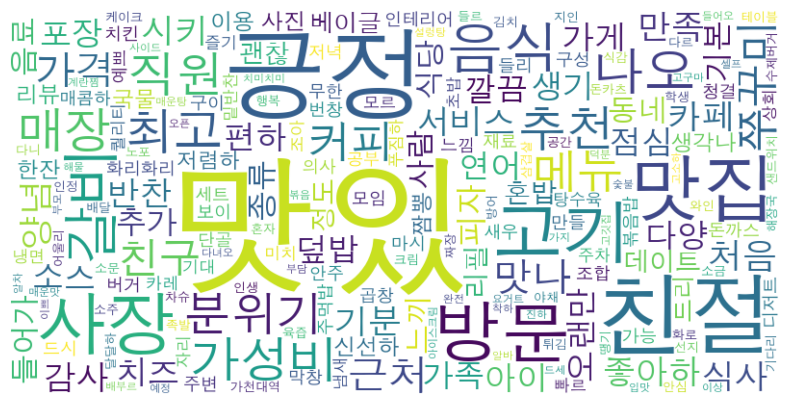

In [32]:
# CODE CELL (다음 단계 예시)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. 'Review_final' 컬럼에 있는 모든 단어 리스트들을 하나의 큰 리스트로 합칩니다.
all_words = []
for words in df['Review_final']:
    all_words.extend(words)

# 2. 파이썬의 Counter를 이용해 각 단어의 빈도를 셉니다.
from collections import Counter
word_counts = Counter(all_words)

# 3. 가장 많이 등장한 단어 50개를 확인합니다.
print("--------- 가장 많이 언급된 단어 TOP 50 ---------")
print(word_counts.most_common(50))

# 4. 워드 클라우드를 생성합니다. (한글 폰트 경로를 지정해야 합니다)
# Mac의 경우: font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf'
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf' 
wordcloud = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_counts)

# 5. 워드 클라우드를 화면에 보여줍니다.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # 축은 보이지 않게
plt.show()

In [50]:
word_counts.most_common(200)

[('맛있', 11638),
 ('긍정', 4028),
 ('친절', 3045),
 ('맛집', 1919),
 ('고기', 1714),
 ('사장', 1701),
 ('방문', 1635),
 ('갈비', 1190),
 ('음식', 1063),
 ('나오', 898),
 ('가성비', 833),
 ('최고', 824),
 ('직원', 793),
 ('추천', 781),
 ('매장', 773),
 ('메뉴', 720),
 ('분위기', 710),
 ('쭈꾸미', 652),
 ('커피', 624),
 ('친구', 558),
 ('근처', 541),
 ('가격', 519),
 ('맛나', 507),
 ('양념', 416),
 ('처음', 396),
 ('카페', 374),
 ('시키', 369),
 ('만족', 366),
 ('식사', 362),
 ('기분', 357),
 ('좋아하', 346),
 ('감사', 345),
 ('반찬', 341),
 ('서비스', 333),
 ('연어', 322),
 ('덮밥', 321),
 ('다양', 316),
 ('소스', 307),
 ('아이', 299),
 ('피자', 298),
 ('포장', 293),
 ('깔끔', 287),
 ('가게', 285),
 ('점심', 279),
 ('편하', 277),
 ('치즈', 269),
 ('오랜만', 264),
 ('생기', 258),
 ('가족', 249),
 ('추가', 243),
 ('식당', 239),
 ('기본', 238),
 ('종류', 237),
 ('동네', 233),
 ('들어가', 228),
 ('사람', 223),
 ('느끼', 220),
 ('음료', 220),
 ('혼밥', 216),
 ('리필', 215),
 ('정도', 213),
 ('데이트', 207),
 ('괜찮', 203),
 ('베이글', 203),
 ('드리', 202),
 ('생각나', 197),
 ('이용', 195),
 ('짬뽕', 193),
 ('사진', 192),
 ('국물', 190),


### 직접 단어 사전 만들기 

In [11]:
df = pd.read_csv('gachon_reviews_preprocessed.csv')

In [13]:
df

,Restaurant,Nickname,Review,Date,Revisit_Count,Reviewer_Review_Count,Reviewer_Photo_Count,Review_cleaned,POS_tagged,Review_final
0,회스시,JREVE,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...,8.19.화,1,221,11,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요 새우튀김...,"[('친구', 'NNG'), ('랑', 'JKB'), ('오랜만', 'NNG'), ...","['친구', '오랜만', '예약', '지나', '들어가', '맛집', '새우', '..."
1,회스시,xmdnlxl2666,멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋,8.25.월,1,16,8,멍게좋아하는데 엄청신선하고 맛있네요새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다긍정,"[('멍게', 'NNP'), ('좋아하', 'VV'), ('는데', 'EC'), (...","['멍게', '좋아하', '신선하', '맛있', '새우', '튀김', '튀기', '..."
2,회스시,asdfasdfa72,가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...,7.9.수,1,76,21,가성비 진짜 너무 좋아요 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 소문...,"[('가성비', 'NNG'), ('진짜', 'MAG'), ('너무', 'MAG'),...","['가성비', '주변', '맛있', '가성비', '소문나', '맛있']"
3,회스시,jsm****,세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...,8.9.토,1,12,4,세트 구성도 너무 좋아요 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄청 ...,"[('세트', 'NNG'), ('구성', 'NNG'), ('도', 'JX'), ('...","['세트', '구성', '매운탕', '시원하', '신선하', '맛있', '기대', ..."
4,회스시,잉딩11,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,8.21.목,1,78,16,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,"[('남자친구', 'NNP'), ('랑', 'JKB'), ('회', 'NNG'), ...","['남자친구', '푸짐하', '서비스']"
...,...,...,...,...,...,...,...,...,...,...
18865,리우차이 성남가천대점,탱글이83,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요!\n다음에도 지인들이랑 방문하게되는 맛이네요~,24.8.16.금,2,131,2,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요다음에도 지인들이랑 방문하게되는 맛이네요,"[('차돌', 'NNG'), ('밥', 'NNG'), ('이랑', 'JC'), ('...","['차돌', '중국', '냉면', '맛있', '지인', '방문']"
18866,리우차이 성남가천대점,jms317897,맛있다!,24.8.17.토,1,15,12,맛있다,"[('맛있', 'VA'), ('다', 'EF')]",['맛있']
18867,리우차이 성남가천대점,션장,맛있어요~~~,24.8.17.토,1,15,17,맛있어요,"[('맛있', 'VA'), ('어요', 'EF')]",['맛있']
18868,리우차이 성남가천대점,h10****,여기 맛집임,24.7.27.토,1,7,5,여기 맛집임,"[('여기', 'NP'), ('맛집', 'NNG'), ('이', 'VCP'), ('...",['맛집']


In [18]:
# CODE CELL (수정된 최종 버전)
import pandas as pd
import ast # 문자열을 파이썬 객체(리스트, 딕셔너리 등)로 변환하는 라이브러리

# (중요!) 전처리가 완료된 'preprocessed' 파일을 불러옵니다.
df = pd.read_csv("gachon_reviews_preprocessed.csv")


# --- ✨✨✨ 여기가 이번 문제의 핵심 해결책! ✨✨✨ ---
# 1. 'Review_final' 컬럼의 데이터 타입을 진짜 '리스트'로 변환합니다.
#    df['Review_final']의 각 셀에 ast.literal_eval 함수를 적용(apply)합니다.
print("문자열 타입을 리스트 타입으로 변환합니다...")
df['Review_final'] = df['Review_final'].apply(ast.literal_eval)
print("변환 완료!")
# --------------------------------------------------


# 2. 감성 사전을 정의합니다.
positive_words = [
    '맛집', '좋아하', '가성비', '친절', '감사', '만족', '추천', '깔끔', 
    '편하', '신선하', '푸짐하', '맛나', '행복', '최고', '인생', '기분', '방문', '긍정',
    '서비스', '다양', '저렴하','번창','단골', '청결', '예쁘', '착하', '맛있', '좋았'
]
negative_words = [
    '아쉽', '아쉬움', '느끼하', '별로', '실망', '냄새', '기다리', '시끄럽',
    '불친절', '비싸', '부정','부담', '이상', '맛없'
]

# 3. 감성 점수 계산 함수를 정의합니다.
def calculate_sentiment_score(word_list):
    score = 0
    # 이제 word_list는 진짜 리스트이므로, word에는 '친구', '맛집' 등이 정상적으로 들어갑니다.
    for word in word_list:
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1
    return score

# 4. 'Review_final' 컬럼에 함수를 적용하여 'Sentiment_Score' 컬럼을 새로 만듭니다.
df['Sentiment_Score'] = df['Review_final'].apply(calculate_sentiment_score)

# 5. 결과를 확인합니다.
print("\n--------- 감성 점수 계산 결과 ---------")
# 점수가 0이 아닌 값들로 채워졌는지 확인합니다.
print(df[['Review', 'Review_final', 'Sentiment_Score']].head(10))

문자열 타입을 리스트 타입으로 변환합니다...
변환 완료!

--------- 감성 점수 계산 결과 ---------
                                              Review  \
0  친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...   
1   멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋   
2  가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...   
3  세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...   
4                남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요   
5  회 땡겨서 먹으러 갔는데 회가 엄청 신선하고 다른 메뉴도 하나같이 다 맛있었어용 !...   
6  와 여기 회 왜이렇게 맛있어용?!👍🏻🤣 그동안 남자친구랑 이곳저곳 해산물 맛집은 돌...   
7  활어초밥 너무 좋아해서 친구가 추천해줘서 와봤는데\n회두께도 적당하고 진짜 맛잇네요...   
8  지인추천으로 왔는데 모둠회 초밥 같이있어서 너무 좋았어요 ㅎㅎ 매운탕도 깔끔하고 비...   
9  회 맛집이에요!!\n그리고 찐맛집은 매운탕이랑 사이드가 맛있어야하는데,\n여긴 튀김...   

                                        Review_final  Sentiment_Score  
0             [친구, 오랜만, 예약, 지나, 들어가, 맛집, 새우, 튀김, 긍정]                2  
1                 [멍게, 좋아하, 신선하, 맛있, 새우, 튀김, 튀기, 긍정]                4  
2                        [가성비, 주변, 맛있, 가성비, 소문나, 맛있]                4  
3    [세트, 구성, 매운탕, 시원하, 신선하, 

In [98]:
# CODE CELL (다음 단계 예시)

# 1. 식당별로 그룹을 묶고, 각 식당의 'Sentiment_Score'의 평균을 계산합니다.
average_scores = df.groupby('Restaurant')['Sentiment_Score'].mean()

# 2. 평균 점수가 높은 순서대로 정렬합니다.
top_restaurants = average_scores.sort_values(ascending=False)

print("--------- 식당별 평균 감성 점수 TOP 10 ---------")
print(top_restaurants.head(10))

print("\n--------- 식당별 평균 감성 점수 BOTTOM 10 ---------")
print(top_restaurants.tail(10))

--------- 식당별 평균 감성 점수 TOP 10 ---------
Restaurant
필그림로스터스 커피랩        5.000000
금룡마라탕              3.272727
코코레모넛베이크샵          3.222222
영울장인               3.130435
그날의 분위기            3.031447
플로우틴 떡케이크          3.029412
바다왕국아구찜&해물찜 성남점    3.028369
무화과나무아래            3.021277
동대문엽기떡볶이 성남태평점     2.708333
꾸덕                 2.702381
Name: Sentiment_Score, dtype: float64

--------- 식당별 평균 감성 점수 BOTTOM 10 ---------
Restaurant
신의한컵 가천대점            0.463542
이디야커피 가천대점           0.461538
파스쿠찌 가천대점            0.452381
노마진아이스크림할인점 성남태평점    0.449438
투썸플레이스 가천대점          0.443299
던킨 가천대점              0.422680
더맘                   0.388889
피자스쿨 성남태평점           0.285714
가천대학교 교육대학원지점        0.133333
자연대가보리밥              0.000000
Name: Sentiment_Score, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


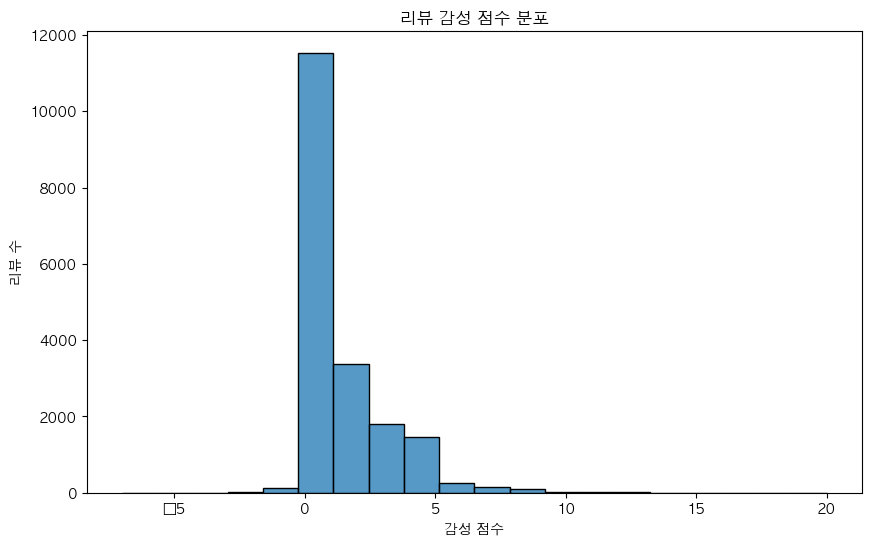

In [17]:
# CODE CELL (다음 단계 예시)
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정을 해줘야 그래프에서 한글이 깨지지 않습니다.
plt.rcParams['font.family'] = 'AppleGothic' # Mac 사용자
# plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자

plt.figure(figsize=(10, 6))
sns.histplot(df['Sentiment_Score'], bins=20, kde=False)
plt.title('리뷰 감성 점수 분포')
plt.xlabel('감성 점수')
plt.ylabel('리뷰 수')
plt.show()

전체 리뷰 수: 18870
감성 점수 0점 이하인 부정/중립 리뷰 수: 128

--------- 부정/중립 리뷰에서 가장 많이 언급된 단어 TOP 50 ---------
[('기다리', 37), ('냄새', 27), ('비싸', 26), ('나오', 23), ('가격', 20), ('이상', 19), ('시키', 16), ('부담', 15), ('고기', 15), ('피자', 12), ('사장', 10), ('부정', 10), ('실망', 10), ('맛없', 9), ('커피', 9), ('기대', 8), ('쭈꾸미', 8), ('사람', 8), ('메뉴', 8), ('음식', 7), ('맛있', 7), ('음료', 7), ('직원', 7), ('모르', 6), ('들어가', 6), ('심하', 6), ('치즈', 6), ('생기', 6), ('카페', 6), ('반찬', 6), ('친구', 5), ('즐기', 5), ('분위기', 5), ('네이버', 5), ('대기', 5), ('리뷰', 5), ('가능', 5), ('땡기', 5), ('뿌리', 5), ('나쁘', 5), ('포장', 5), ('처음', 5), ('혼자', 4), ('숯불', 4), ('갈비', 4), ('식사', 4), ('만들', 4), ('라면', 4), ('비하', 4), ('화리화리', 4)]

--------- 부정/중립 리뷰 워드 클라우드 ---------


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47549 (\N{HANGUL SYLLABLE RIB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

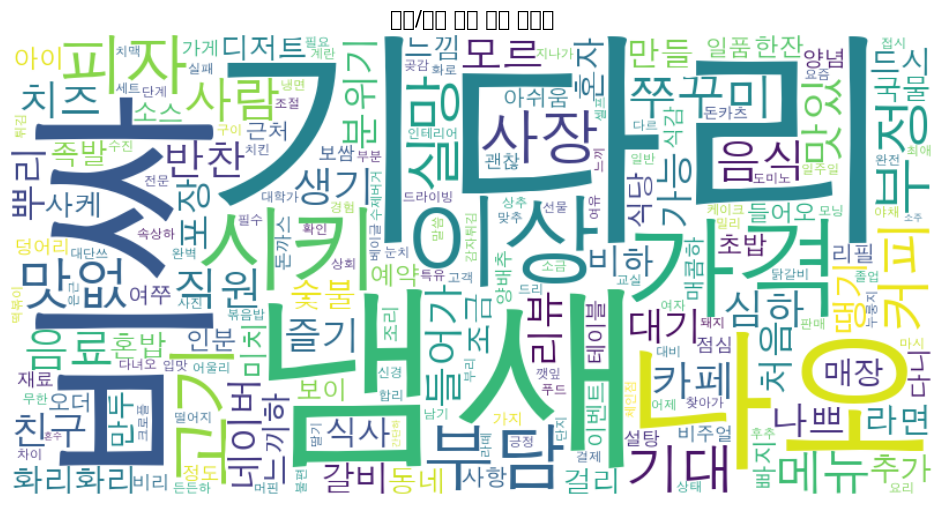

In [7]:
# -----------------------------------------------------------------
# PART 0: 필요한 도구들을 미리 불러옵니다.
# -----------------------------------------------------------------
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast # 문자열로 저장된 리스트를 진짜 리스트로 변환하기 위해 필요

# -----------------------------------------------------------------
# PART 1: 데이터 준비
# -----------------------------------------------------------------
# 전처리와 감성 점수 계산이 모두 완료된 CSV 파일을 불러옵니다.
# (이전에 저장한 파일 이름을 정확하게 입력해주세요)
try:
    # 'Review_final' 컬럼이 문자열 형태일 경우, 진짜 리스트로 변환합니다.
    if isinstance(df['Review_final'].iloc[0], str):
        df['Review_final'] = df['Review_final'].apply(ast.literal_eval)
except FileNotFoundError:
    print("오류: 감성 점수가 포함된 전처리 완료 파일을 찾을 수 없습니다. 파일 이름을 확인해주세요.")
    # 또는, 이전 단계 코드를 여기에 붙여넣어 df를 바로 생성해도 됩니다.
    exit()

# -----------------------------------------------------------------
# PART 2: 부정적인 리뷰만 골라내기
# -----------------------------------------------------------------
print("전체 리뷰 수:", len(df))

# 감성 점수가 0점 이하인 리뷰들만 필터링하여 'negative_df'라는 새로운 DataFrame을 만듭니다.
negative_df = df[df['Sentiment_Score'] < 0].copy() # .copy()를 붙여주면 깔끔합니다.

print("감성 점수 0점 이하인 부정/중립 리뷰 수:", len(negative_df))

# -----------------------------------------------------------------
# PART 3: 부정 리뷰에 포함된 단어들의 빈도수 계산
# -----------------------------------------------------------------
# 1. 부정 리뷰의 'Review_final' 컬럼에 있는 모든 단어 리스트들을 하나의 큰 리스트로 합칩니다.
all_negative_words = []
for words in negative_df['Review_final']:
    all_negative_words.extend(words)

# 2. Counter를 이용해 각 단어의 빈도를 셉니다.
negative_word_counts = Counter(all_negative_words)

# 3. 가장 많이 등장한 부정 관련 단어 50개를 확인합니다.
print("\n--------- 부정/중립 리뷰에서 가장 많이 언급된 단어 TOP 50 ---------")
print(negative_word_counts.most_common(50))


# -----------------------------------------------------------------
# PART 4: 부정 리뷰 워드 클라우드 생성 및 시각화
# -----------------------------------------------------------------
# 4. 한글 폰트 경로를 설정합니다. (사용자 환경에 맞게 수정)
# Mac의 경우: font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf'
# Windows의 경우: font_path='c:/Windows/Fonts/malgun.ttf'
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf' 

# 5. 워드 클라우드 객체를 생성합니다.
negative_wordcloud = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(negative_word_counts)

# 6. 워드 클라우드를 화면에 예쁘게 보여줍니다.
print("\n--------- 부정/중립 리뷰 워드 클라우드 ---------")
plt.figure(figsize=(12, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('부정/중립 리뷰 핵심 키워드', size=15)
plt.axis('off') # 축은 보이지 않게
plt.show()

### 수작업 : 4개의 기준으로 별점 매기기

In [394]:
# CODE CELL 1: 데이터 로드 및 사전 정의
import pandas as pd
import ast

# 1. 전처리 완료된 데이터를 불러옵니다.
df = pd.read_csv("gachon_reviews_preprocessed.csv") 

# 2. (가장 중요!) 'Review_final' 컬럼을 문자열에서 진짜 리스트로 변환합니다.
if isinstance(df['Review_final'].iloc[0], str):
    df['Review_final'] = df['Review_final'].apply(ast.literal_eval)

# 3. 긍정/부정 및 속성 키워드 사전을 정의합니다.
positive_words = [
    '맛집', '좋아하', '가성비', '친절', '감사', '만족', '추천', '깔끔', 
    '편하', '신선하', '푸짐하', '맛나', '행복', '최고', '인생', '기분', '방문', '긍정',
    '서비스', '다양', '저렴하','번창','단골', '청결', '예쁘', '착하', '맛있', '좋았'
]
negative_words = [
    '아쉽', '아쉬움', '느끼하', '별로', '실망', '냄새', '기다리', '시끄럽',
    '불친절', '비싸', '부정','부담', '이상', '맛없', '밍밍', '싱겁다', '더럽'
]
aspect_keywords = {
    '맛': ['맛', '맛집', '맛있', '신선하', '음식', '메뉴', '커피', '피자', '치킨', '반찬', 
           '소스', '국물', '덮밥', '갈비', '냉면', '돈까스', '새우', '연어', '양념', 
           '튀김', '퀄리티', '재료', '짜다', '느끼하', '맛없'],
    '가격': ['가성비', '가격', '저렴하', '비싸', '부담', '할인', '쿠폰'],
    '서비스': ['직원', '사장님', '친절', '서비스', '응대', '감사', '불친절', '설명', '예약'],
    '분위기': ['분위기', '매장', '인테리어', '깔끔', '편하', '청결', '공간', '자리', '대기',
             '웨이팅', '시끄럽', '모임', '데이트', '혼밥', '주차', '사진']
}

print("STEP 1: 데이터 로드 및 사전 정의 완료!")


# CODE CELL 2: 전체 감성 점수 계산
intensifier_dict = {
    '너무': 1.5,
    '진짜': 1.3,
    '완전': 1.5,
    '엄청': 1.4,
    '최고': 1.5, # '최고'는 긍정단어이면서 동시에 강조의 의미도 가질 수 있습니다.
    '좀': 0.8,
    '조금': 0.8,
    '살짝': 0.7
}
# -----------------------------------------------------------

# # --- ✨✨✨ 여기가 이번 문제의 최종 해결책! ✨✨✨ ---
# # 2. 속성별 점수를 '개별적으로' 계산하는 새로운 함수를 정의합니다.
# def calculate_final_aspect_scores(word_list):
#     scores = {'맛_점수': 0.0, '가격_점수': 0.0, '서비스_점수': 0.0, '분위기_점수': 0.0}
    
#     # 단어 목록을 순회하며 점수를 계산
#     for i, word in enumerate(word_list):
#         base_score = 0
#         if word in positive_words:
#             base_score = 1
#         elif word in negative_words:
#             base_score = -1
        
#         if base_score == 0:
#             continue

#         weight = 1.0
#         if i > 0:
#             previous_word = word_list[i-1]
#             if previous_word in intensifier_dict:
#                 weight = intensifier_dict[previous_word]
        
#         final_score = base_score * weight
        
#         # (중요!) 이 단어가 어떤 속성에 해당하는지 찾아서, 해당 속성의 점수만 업데이트합니다.
#         for aspect, keywords in aspect_keywords.items():
#             if word in keywords:
#                 scores[f'{aspect}_점수'] += final_score
    
#     return pd.Series(scores)

# # 3. 새로운 함수를 전체 데이터에 적용하여, 4개의 속성 점수 컬럼을 바로 생성합니다.
# print("새로운 방식으로 속성별 감성 점수 계산을 시작합니다...")
# aspect_scores_df = df['Review_final'].apply(calculate_final_aspect_scores)
# # 기존 df에 있는 옛날 점수 컬럼은 지우고, 새로운 점수로 업데이트 합니다.
# df = df.drop(columns=['맛_점수', '가격_점수', '서비스_점수', '분위기_점수'], errors='ignore')
# df = pd.concat([df, aspect_scores_df], axis=1)
# print("계산 완료!")


# # 4. 이제 'Sentiment_Score'는 각 속성 점수의 '합계'로 새롭게 정의합니다.
# df['Sentiment_Score'] = df[['맛_점수', '가격_점수', '서비스_점수', '분위기_점수']].sum(axis=1)


# # 5. 최종 결과를 확인합니다.
# print("\n--------- 최종 결과 (상위 5개) ---------")
# print(df[['Review_final', 'Sentiment_Score', '맛_점수', '가격_점수', '서비스_점수', '분위기_점수']].head())

# # 6. 식당별 평균 점수도 다시 계산합니다.
# score_cols = ['맛_점수', '가격_점수', '서비스_점수', '분위기_점수']
# restaurant_aspect_scores = df.groupby('Restaurant')[score_cols].mean()
# print("\n--------- (수정 후) 식당별 평균 속성 점수 (상위 10개) ---------")
# pd.options.display.float_format = '{:.2f}'.format
# print(restaurant_aspect_scores.head(10))


# ---------------


# CODE CELL 2 (FINAL & ROBUST v2): 주변 단어 탐색 기반 점수 시스템
# CODE CELL 2 (FINAL & INDUSTRY-STANDARD): 신뢰도 보정 점수 시스템

# 1. 계산에 필요한 사전과 가중치 정의 (기존과 동일)
intensifier_dict = {
    '너무': 1.5, '진짜': 1.3, '완전': 1.5, '엄청': 1.4, '최고': 1.5,
    '좀': 0.8, '조금': 0.8, '살짝': 0.7
}
# (positive_words, negative_words, aspect_keywords 사전은 CODE CELL 1에서 이미 정의됨)

# --- ✨✨✨ 여기가 완전히 새로워진 최종 핵심 로직! ✨✨✨ ---
# 2. 식당 하나(의 리뷰 그룹)를 통째로 받아, 신뢰도를 보정한 점수를 계산하는 함수
def calculate_bayesian_average_scores(group, C=5, m=0.5):
    # C: 신뢰도 보정 강도. 가상의 리뷰 개수라고 생각할 수 있습니다. 클수록 점수가 중간값에 가까워집니다.
    # m: 사전 확률. 긍정 리뷰의 기본 비율을 의미합니다. (0.5는 긍정:부정=50:50을 의미)
    
    aspect_sentiment_totals = {
        '맛': {'pos': 0.0, 'neg': 0.0}, '가격': {'pos': 0.0, 'neg': 0.0},
        '서비스': {'pos': 0.0, 'neg': 0.0}, '분위기': {'pos': 0.0, 'neg': 0.0}
    }
    
    # Part 1: 각 속성에 대한 긍정/부정 언급 횟수(가중치 포함) 집계
    for word_list in group['Review_final']:
        for i, word in enumerate(word_list):
            base_score, assigned_aspect = 0, None
            if word in positive_words: base_score = 1
            elif word in negative_words: base_score = -1
            if base_score == 0: continue

            weight = 1.0
            if i > 0 and word_list[i-1] in intensifier_dict:
                weight = intensifier_dict[word_list[i-1]]
            final_score = base_score * weight

            for aspect, keywords in aspect_keywords.items():
                if word in keywords:
                    assigned_aspect = aspect
                    break
            
            if not assigned_aspect:
                window_size = 2
                start, end = max(0, i - window_size), min(len(word_list), i + window_size + 1)
                for j in range(start, end):
                    if i == j: continue
                    for aspect, keywords in aspect_keywords.items():
                        if word_list[j] in keywords:
                            assigned_aspect = aspect
                            break
                    if assigned_aspect: break
            
            if assigned_aspect:
                if final_score > 0:
                    aspect_sentiment_totals[assigned_aspect]['pos'] += final_score
                else:
                    aspect_sentiment_totals[assigned_aspect]['neg'] += abs(final_score)

    # Part 2: 베이지안 평균 공식을 사용하여 최종 5점 만점 점수 계산
    final_scores = {}
    for aspect, totals in aspect_sentiment_totals.items():
        pos_total, neg_total = totals['pos'], totals['neg']
        
        # 베이지안 평균 공식: (실제 긍정 수 + 가상 긍정 수) / (전체 실제 수 + 전체 가상 수)
        # 가상 긍정 수 = C * m, 전체 가상 수 = C
        bayesian_ratio = (pos_total + C * m) / (pos_total + neg_total + C)
        final_score = bayesian_ratio * 5.0
        
        final_scores[f'{aspect}_점수'] = final_score

    # Part 3: 리뷰 수도 함께 계산하여 반환
    results = pd.Series(final_scores)
    results['Total_Reviews'] = len(group)
    return results

# 3. 새로운 통합 함수를 전체 데이터에 적용
print("신뢰도 보정 점수 시스템으로 재계산을 시작합니다...")
# C 값을 조절하여 보정 강도를 바꿀 수 있습니다. (리뷰가 적은 데이터셋에서는 5~10 정도가 적당)
df = df.groupby('Restaurant').apply(lambda g: calculate_bayesian_average_scores(g, C=5)).reset_index()
print("계산 완료!")

# 4. 최종 점수(Final_Rating) 계산
score_cols = ['맛_점수', '가격_점수', '서비스_점수', '분위기_점수']
df['Final_Rating'] = df_ranking_new[score_cols].mean(axis=1)

# 5. 최종 랭킹 확인
df= df.sort_values(by='Final_Rating', ascending=False).reset_index(drop=True)
print("\n--------- (최종 수정 후) 식당 랭킹 (상위 10개) ---------")
pd.options.display.float_format = '{:.2f}'.format
df = df[['Restaurant', '맛_점수', '가격_점수', '서비스_점수', '분위기_점수']]

STEP 1: 데이터 로드 및 사전 정의 완료!
신뢰도 보정 점수 시스템으로 재계산을 시작합니다...
계산 완료!

--------- (최종 수정 후) 식당 랭킹 (상위 10개) ---------


/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1510/3543910257.py:183: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Restaurant').apply(lambda g: calculate_bayesian_average_scores(g, C=5)).reset_index()


In [396]:
### CODE CELL (최종 결과물 저장) #####

# 사전 (내가 직접 정의한) 기반 점수 결과물 !!


# 2. 식당별 평균 점수 요약본 DataFrame 저장
#    - 'Restaurant'가 인덱스로 되어 있으므로, reset_index()를 사용해 일반 컬럼으로 바꿔준 뒤 저장하는 것이 좋습니다.
print("\n식당별 평균 점수 요약본을 저장합니다...")
df.reset_index().to_csv("gachon_restaurant_aspect_summary.csv", index=False, encoding='utf-8-sig')
print("'gachon_restaurant_aspect_summary.csv' 파일 저장 완료!")


식당별 평균 점수 요약본을 저장합니다...
'gachon_restaurant_aspect_summary.csv' 파일 저장 완료!


### kobert 모델 이용하기

In [37]:
# CODE CELL 1
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. 모델과 토크나이저를 Hugging Face Hub에서 다운로드합니다.
#    이 코드를 처음 실행하면 모델을 다운로드하느라 시간이 걸릴 수 있습니다.
MODEL_NAME = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

print("KoELECTRA 감성 분석 모델 로딩 완료!")

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

KoELECTRA 감성 분석 모델 로딩 완료!


In [43]:
# CODE CELL (Review_cleaned 컬럼 사용)
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import ast

# 1. 서영님이 가지고 계신, 모든 전처리가 끝난 데이터 파일을 불러옵니다.
df = pd.read_csv("gachon_reviews_preprocessed.csv")

# 2. 모델과 토크나이저를 로딩합니다. (이전과 동일)
MODEL_NAME = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# 3. KoELECTRA 감성 분석 함수를 정의합니다. (이전과 동일)
def get_koelectra_sentiment(text):
    text = str(text)[:512]
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment_score = probabilities[0][1].item() - probabilities[0][0].item()
        return sentiment_score
    except Exception:
        return 0

# 4. (중요!) 'Review_cleaned' 컬럼에 함수를 적용합니다.
#    테스트를 위해 100개만 먼저 실행해봅니다.
df_sample = df.head(100).copy()

print("\nKoELECTRA 감성 분석을 시작합니다 (입력: Review_cleaned)...")
df_sample['KoELECTRA_Score'] = df_sample['Review_cleaned'].apply(get_koelectra_sentiment)
print("KoELECTRA 감성 분석 완료!")

# 5. 결과 확인
print("\n--------- KoELECTRA 감성 점수 계산 결과 ---------")
print(df_sample[['Review_cleaned', 'KoELECTRA_Score']].head(20))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



KoELECTRA 감성 분석을 시작합니다 (입력: Review_cleaned)...
KoELECTRA 감성 분석 완료!

--------- KoELECTRA 감성 점수 계산 결과 ---------
                                       Review_cleaned  KoELECTRA_Score
0   친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요 새우튀김...             0.99
1       멍게좋아하는데 엄청신선하고 맛있네요새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다긍정             0.97
2   가성비 진짜 너무 좋아요 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 소문...             0.98
3   세트 구성도 너무 좋아요 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄청 ...             0.99
4                 남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요             0.99
5   회 땡겨서 먹으러 갔는데 회가 엄청 신선하고 다른 메뉴도 하나같이 다 맛있었어용 둘...             0.99
6   와 여기 회 왜이렇게 맛있어용 긍정 그동안 남자친구랑 이곳저곳 해산물 맛집은 돌아다...             0.99
7        활어초밥 너무 좋아해서 친구가 추천해줘서 와봤는데회두께도 적당하고 진짜 맛잇네요             0.99
8   지인추천으로 왔는데 모둠회 초밥 같이있어서 너무 좋았어요 매운탕도 깔끔하고 비린내안...             0.99
9   회 맛집이에요그리고 찐맛집은 매운탕이랑 사이드가 맛있어야하는데여긴 튀김 구이 탕 다...             0.98
10  여기저기서 도미 먹어봤는데 여기는 진짜 손꼽을 정도입니당 친구랑 연신 감탄하면서 먹...             0.99
11  맛집 찾았어요 회가 진짜 신선하구 맛있음 그자체 기대 안 하

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


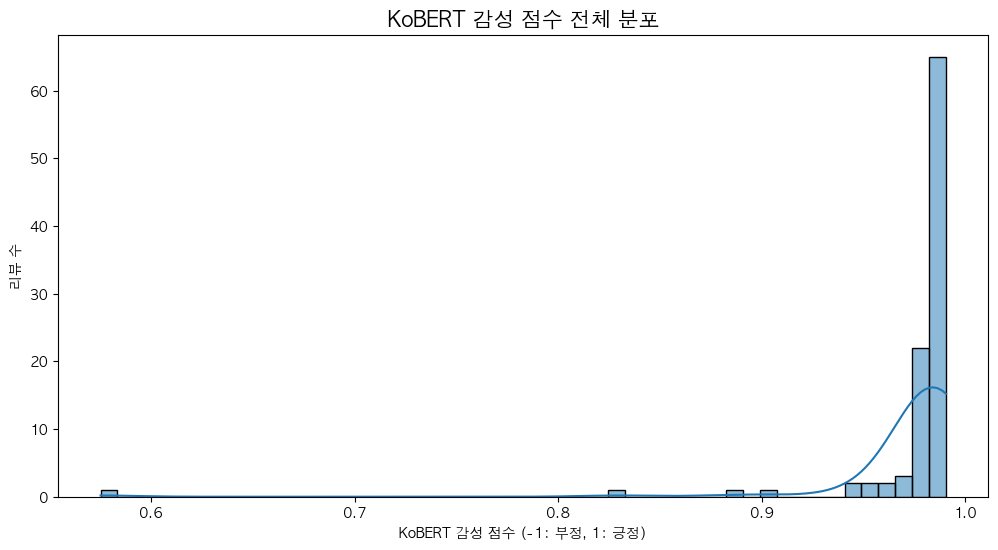

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic' # Mac 사용자
plt.figure(figsize=(12, 6))
sns.histplot(df_sample['KoELECTRA_Score'], bins=50, kde=True)
plt.title('KoBERT 감성 점수 전체 분포', size=15)
plt.xlabel('KoBERT 감성 점수 (-1: 부정, 1: 긍정)')
plt.ylabel('리뷰 수')
plt.show()

In [26]:
# CODE CELL (긍정/부정 이진 라벨링)
import pandas as pd
import ast

# 1. 데이터를 불러오고 'Review_final' 컬럼을 리스트로 변환합니다.
df = pd.read_csv("gachon_reviews_preprocessed.csv")
if isinstance(df['Review_final'].iloc[0], str):
    df['Review_final'] = df['Review_final'].apply(ast.literal_eval)

# 2. 긍정/부정 단어 사전을 정의합니다. (이전과 동일)
positive_words = [
    '맛집', '좋아하', '가성비', '친절', '감사', '만족', '추천', '깔끔', 
    '편하', '신선하', '푸짐하', '맛나', '행복', '최고', '인생', '기분', '방문', '긍정',
    '서비스', '다양', '저렴하','번창','단골', '청결', '예쁘', '착하', '맛있', '좋았'
]
negative_words = [
    '아쉽', '아쉬움', '느끼하', '별로', '실망', '냄새', '기다리', '시끄럽',
    '불친절', '비싸', '부정','부담', '이상', '맛없'
]

# --- ✨✨✨ 여기가 서영님의 요청이 반영된 핵심 수정 부분! ✨✨✨ ---
# 3. 오직 '긍정', '부정', '중립'만 판단하는 간단한 자동 라벨링 함수를 정의합니다.
def simple_auto_labeler(word_list):
    # 긍정/부정 단어의 '개수'를 셉니다.
    pos_count = sum(1 for word in word_list if word in positive_words)
    neg_count = sum(1 for word in word_list if word in negative_words)
    
    # 규칙에 따라 '긍정', '부정', '중립' 중 하나만 반환합니다.
    if pos_count > neg_count:
        return '긍정'
    elif neg_count > pos_count:
        return '부정'
    else: # 둘의 개수가 같거나, 둘 다 0개이면 '중립'
        return '중립'

# 4. 'Auto_Labels' 컬럼을 새로운 함수로 다시 만듭니다.
df['Auto_Labels'] = df['Review_final'].apply(simple_auto_labeler)
# ----------------------------------------------------------------

# 5. '중립'으로 분류된 리뷰는 학습 데이터에서 제외하여, 긍정/부정의 특징을 더 명확하게 학습시킵니다.
ft_df = df[df['Auto_Labels'] != '중립'].copy()

print("--------- 새로운 라벨링 결과 (상위 10개) ---------")
print(ft_df[['Review', 'Auto_Labels']].head(10))

print("\n--------- 최종 라벨 분포 확인 ---------")
print(ft_df['Auto_Labels'].value_counts())

--------- 새로운 라벨링 결과 (상위 10개) ---------
                                              Review Auto_Labels
0  친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...          긍정
1   멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋          긍정
2  가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...          긍정
3  세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...          긍정
4                남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요          긍정
5  회 땡겨서 먹으러 갔는데 회가 엄청 신선하고 다른 메뉴도 하나같이 다 맛있었어용 !...          긍정
6  와 여기 회 왜이렇게 맛있어용?!👍🏻🤣 그동안 남자친구랑 이곳저곳 해산물 맛집은 돌...          긍정
7  활어초밥 너무 좋아해서 친구가 추천해줘서 와봤는데\n회두께도 적당하고 진짜 맛잇네요...          긍정
8  지인추천으로 왔는데 모둠회 초밥 같이있어서 너무 좋았어요 ㅎㅎ 매운탕도 깔끔하고 비...          긍정
9  회 맛집이에요!!\n그리고 찐맛집은 매운탕이랑 사이드가 맛있어야하는데,\n여긴 튀김...          긍정

--------- 최종 라벨 분포 확인 ---------
Auto_Labels
긍정    13411
부정      128
Name: count, dtype: int64


In [30]:
ft_df

,Restaurant,Nickname,Review,Date,Revisit_Count,Reviewer_Review_Count,Reviewer_Photo_Count,Review_cleaned,POS_tagged,Review_final,Auto_Labels
0,회스시,JREVE,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...,8.19.화,1,221,11,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요 새우튀김...,"[('친구', 'NNG'), ('랑', 'JKB'), ('오랜만', 'NNG'), ...","[친구, 오랜만, 예약, 지나, 들어가, 맛집, 새우, 튀김, 긍정]",긍정
1,회스시,xmdnlxl2666,멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋,8.25.월,1,16,8,멍게좋아하는데 엄청신선하고 맛있네요새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다긍정,"[('멍게', 'NNP'), ('좋아하', 'VV'), ('는데', 'EC'), (...","[멍게, 좋아하, 신선하, 맛있, 새우, 튀김, 튀기, 긍정]",긍정
2,회스시,asdfasdfa72,가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...,7.9.수,1,76,21,가성비 진짜 너무 좋아요 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 소문...,"[('가성비', 'NNG'), ('진짜', 'MAG'), ('너무', 'MAG'),...","[가성비, 주변, 맛있, 가성비, 소문나, 맛있]",긍정
3,회스시,jsm****,세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...,8.9.토,1,12,4,세트 구성도 너무 좋아요 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄청 ...,"[('세트', 'NNG'), ('구성', 'NNG'), ('도', 'JX'), ('...","[세트, 구성, 매운탕, 시원하, 신선하, 맛있, 기대, 기분, 식사, 긍정, 긍정]",긍정
4,회스시,잉딩11,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,8.21.목,1,78,16,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,"[('남자친구', 'NNP'), ('랑', 'JKB'), ('회', 'NNG'), ...","[남자친구, 푸짐하, 서비스]",긍정
...,...,...,...,...,...,...,...,...,...,...,...
18865,리우차이 성남가천대점,탱글이83,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요!\n다음에도 지인들이랑 방문하게되는 맛이네요~,24.8.16.금,2,131,2,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요다음에도 지인들이랑 방문하게되는 맛이네요,"[('차돌', 'NNG'), ('밥', 'NNG'), ('이랑', 'JC'), ('...","[차돌, 중국, 냉면, 맛있, 지인, 방문]",긍정
18866,리우차이 성남가천대점,jms317897,맛있다!,24.8.17.토,1,15,12,맛있다,"[('맛있', 'VA'), ('다', 'EF')]",[맛있],긍정
18867,리우차이 성남가천대점,션장,맛있어요~~~,24.8.17.토,1,15,17,맛있어요,"[('맛있', 'VA'), ('어요', 'EF')]",[맛있],긍정
18868,리우차이 성남가천대점,h10****,여기 맛집임,24.7.27.토,1,7,5,여기 맛집임,"[('여기', 'NP'), ('맛집', 'NNG'), ('이', 'VCP'), ('...",[맛집],긍정


In [32]:
df.to_csv('gachon_reviews_final.csv', index=False, encoding='utf-8-sig')

### koElectra 파인튜닝 하기

In [111]:
df=pd.read_csv('gachon_reviews_final.csv') ### koelectra
df

,Restaurant,Nickname,Review,Date,Revisit_Count,Reviewer_Review_Count,Reviewer_Photo_Count,Review_cleaned,POS_tagged,Review_final,Auto_Labels
0,회스시,JREVE,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...,8.19.화,1,221,11,친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요 새우튀김...,"[('친구', 'NNG'), ('랑', 'JKB'), ('오랜만', 'NNG'), ...","['친구', '오랜만', '예약', '지나', '들어가', '맛집', '새우', '...",긍정
1,회스시,xmdnlxl2666,멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋,8.25.월,1,16,8,멍게좋아하는데 엄청신선하고 맛있네요새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다긍정,"[('멍게', 'NNP'), ('좋아하', 'VV'), ('는데', 'EC'), (...","['멍게', '좋아하', '신선하', '맛있', '새우', '튀김', '튀기', '...",긍정
2,회스시,asdfasdfa72,가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...,7.9.수,1,76,21,가성비 진짜 너무 좋아요 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 소문...,"[('가성비', 'NNG'), ('진짜', 'MAG'), ('너무', 'MAG'),...","['가성비', '주변', '맛있', '가성비', '소문나', '맛있']",긍정
3,회스시,jsm****,세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...,8.9.토,1,12,4,세트 구성도 너무 좋아요 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄청 ...,"[('세트', 'NNG'), ('구성', 'NNG'), ('도', 'JX'), ('...","['세트', '구성', '매운탕', '시원하', '신선하', '맛있', '기대', ...",긍정
4,회스시,잉딩11,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,8.21.목,1,78,16,남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요,"[('남자친구', 'NNP'), ('랑', 'JKB'), ('회', 'NNG'), ...","['남자친구', '푸짐하', '서비스']",긍정
...,...,...,...,...,...,...,...,...,...,...,...
18865,리우차이 성남가천대점,탱글이83,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요!\n다음에도 지인들이랑 방문하게되는 맛이네요~,24.8.16.금,2,131,2,차돌밥이랑 중국냉면 시켰는데 정말 맛있어요다음에도 지인들이랑 방문하게되는 맛이네요,"[('차돌', 'NNG'), ('밥', 'NNG'), ('이랑', 'JC'), ('...","['차돌', '중국', '냉면', '맛있', '지인', '방문']",긍정
18866,리우차이 성남가천대점,jms317897,맛있다!,24.8.17.토,1,15,12,맛있다,"[('맛있', 'VA'), ('다', 'EF')]",['맛있'],긍정
18867,리우차이 성남가천대점,션장,맛있어요~~~,24.8.17.토,1,15,17,맛있어요,"[('맛있', 'VA'), ('어요', 'EF')]",['맛있'],긍정
18868,리우차이 성남가천대점,h10****,여기 맛집임,24.7.27.토,1,7,5,여기 맛집임,"[('여기', 'NP'), ('맛집', 'NNG'), ('이', 'VCP'), ('...",['맛집'],긍정


In [113]:

# CODE CELL 1: 데이터 준비 및 증강
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from googletrans import Translator
import time

# ... (df 만드는 코드는 이전과 동일) ...
ft_df = df[df['Auto_Labels'] != '중립'].copy()
ft_df.rename(columns={'Auto_Labels': 'label'}, inplace=True)




# --- ✨✨✨ 여기가 새로운 부분! (데이터 증강) ✨✨✨ ---
# 2. '부정' 리뷰 데이터만 따로 추출합니다.
df_negative = ft_df[ft_df['label'] == '부정'].copy()
print(f"원본 부정 리뷰 수: {len(df_negative)}")

# 3. 역번역을 위한 번역기 객체를 생성합니다.
translator = Translator()

# 4. 증강된 데이터를 저장할 리스트를 만듭니다.
augmented_texts = []
for text in df_negative['Review']:
    try:
        # 한국어 -> 영어 -> 한국어
        translated_en = translator.translate(text, src='ko', dest='en').text
        time.sleep(1) # API 과부하 방지를 위한 짧은 대기
        back_translated_ko = translator.translate(translated_en, src='en', dest='ko').text
        
        # 원본과 약간이라도 다른 경우에만 추가 (완전히 똑같이 번역되는 경우 제외)
        if text != back_translated_ko:
            augmented_texts.append({
                'sentence': back_translated_ko, 
                'label': '부정' # 라벨은 당연히 '부정'
            })
    except Exception as e:
        print(f"번역 중 오류 발생: {e}")
        continue

# 5. 증강된 데이터를 새로운 DataFrame으로 만듭니다.
df_augmented = pd.DataFrame(augmented_texts)
print(f"새롭게 증강된 부정 리뷰 수: {len(df_augmented)}")

# 6. 원래의 ft_df에 증강된 부정 리뷰 데이터를 합칩니다.
ft_df_augmented = pd.concat([ft_df, df_augmented], ignore_index=True)
print(f"최종 학습 데이터 수: {len(ft_df_augmented)}")
print("\n최종 라벨 분포:")
print(ft_df_augmented['label'].value_counts())

# 7. 'ft_df'가 아닌, 'ft_df_augmented'에 label_id를 만듭니다.
label_to_id = {'긍정': 1, '부정': 0}
ft_df_augmented['label_id'] = ft_df_augmented['label'].map(label_to_id)

# 8. 'ft_df'가 아닌, 'ft_df_augmented'를 사용해 데이터를 분리합니다.
train_df, val_df = train_test_split(
    ft_df_augmented, 
    test_size=0.2, 
    random_state=42,
    stratify=ft_df_augmented['label_id'] )

# 토크나이저 로딩
MODEL_NAME = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("전체 학습 데이터 준비 완료!")
print(f"훈련 데이터 수: {len(train_df)}, 검증 데이터 수: {len(val_df)}")

원본 부정 리뷰 수: 128
번역 중 오류 발생: The read operation timed out
새롭게 증강된 부정 리뷰 수: 127
최종 학습 데이터 수: 13666

최종 라벨 분포:
label
긍정    13411
부정      255
Name: count, dtype: int64
전체 학습 데이터 준비 완료!
훈련 데이터 수: 10932, 검증 데이터 수: 2734


In [31]:
### 내일 해보 (1시간 걸림..)

# CODE CELL (최종 학습 실행)
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. 모델 로딩 (동일)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2, 
    ignore_mismatched_sizes=True
)

# --- ✨✨✨ 여기가 이번 문제의 최종 해결책! ✨✨✨ ---
# 2. Dataset 생성 전, 모든 리뷰를 확실하게 문자열로 변환합니다.
train_text_list = train_df['Review'].astype(str).tolist()
val_text_list = val_df['Review'].astype(str).tolist()

train_encodings = tokenizer(train_text_list, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_text_list, truncation=True, padding=True, max_length=256)



class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_df['label_id'].tolist())
val_dataset = ReviewDataset(val_encodings, val_df['label_id'].tolist())

# 3. 클래스 가중치 계산 (동일)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id'].to_numpy()
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# 4. 커스텀 Trainer 정의 (동일)
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- ✨✨✨ 여기가 생략되었던 부분! ✨✨✨ ---
# 5. 학습 규칙을 '실제 값'으로 설정합니다.
training_args = TrainingArguments(
    output_dir='./results_weighted',      # 학습 결과(체크포인트)가 저장될 폴더
    num_train_epochs=3,                  # 전체 데이터를 3번 반복해서 학습
    per_device_train_batch_size=16,      # 한 번에 16개씩 데이터를 보며 학습
    per_device_eval_batch_size=64,       # 검증 시에는 64개씩
    warmup_steps=500,                    # 초기 학습률을 서서히 올리는 구간
    weight_decay=0.01,                   # 과적합 방지를 위한 가중치 감소
    logging_dir='./logs_weighted',       # 학습 로그가 저장될 폴더
    logging_steps=50,                    # 50번 학습할 때마다 로그 출력
    evaluation_strategy="epoch",         # 한 epoch마다 성능 평가
    save_strategy="epoch",               # 한 epoch마다 모델 저장
    load_best_model_at_end=True,         # 학습 종료 후 가장 성능 좋았던 모델을 불러옴
)

# 6. 커스텀 Trainer를 '실제 값'으로 생성합니다.
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
# ----------------------------------------------------

print("\n클래스 가중치가 적용된 학습 환경 설정 완료!")

# --- STEP 3: 모델 파인튜닝 실행 ---
print("모델 파인튜닝을 시작합니다...")
trainer.train()
print("모델 파인튜닝 완료!")

# 최종 모델 저장
final_model_path = "./my_finetuned_gachon_model_weighted"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"\n🎉 파인튜닝된 모델이 '{final_model_path}' 폴더에 성공적으로 저장되었습니다!")

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



클래스 가중치가 적용된 학습 환경 설정 완료!
모델 파인튜닝을 시작합니다...


Epoch,Training Loss,Validation Loss
1,0.227800,0.657934
2,0.137800,0.102602
3,0.012500,0.104935


모델 파인튜닝 완료!

🎉 파인튜닝된 모델이 './my_finetuned_gachon_model_weighted' 폴더에 성공적으로 저장되었습니다!


In [438]:
# CODE CELL (모델 성능 검증 - 완전체)
import numpy as np
import torch
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


# (중요!) 이 셀을 실행하기 전에, 전체 데이터를 담은 'all_df'가 준비되어 있어야 합니다.

# 기존에 나뉘어 있던 훈련 데이터와 검증 데이터를 다시 합칩니다.
all_df = pd.concat([train_df, val_df], ignore_index=True)


print("--- 교차 검증 기반 모델 성능 평가 시작 ---")

# --- 1. 번역 사전 및 데이터셋 클래스 정의 ---
label_to_id = {'긍정': 1, '부정': 0}
id_to_label = {v: k for k, v in label_to_id.items()}

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# --- 2. K-Fold 설정 ---
# 5-Fold 교차 검증을 사용합니다.
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 각 폴드의 결과를 저장할 리스트를 만듭니다.
all_reports = []

# --- 3. 교차 검증 루프 ---
# all_df를 KFold에 적용하여 인덱스를 나눕니다.
for fold, (train_index, val_index) in enumerate(kf.split(all_df)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} 시작 ---")
    
    # 훈련 데이터와 검증 데이터를 나눕니다.
    train_df = all_df.iloc[train_index]
    val_df = all_df.iloc[val_index]

    # 모델과 토크나이저를 다시 불러옵니다. (각 폴드마다 초기 모델로 시작)
    # 실제 환경에서는 매 폴드마다 모델을 처음부터 학습시키고 평가해야 더 정확합니다.
    MODEL_PATH = "./my_finetuned_gachon_model_weighted"
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    
    # 검증 데이터를 토큰화하고 데이터셋을 만듭니다.
    val_encodings = tokenizer(val_df['Review'].astype(str).tolist(), truncation=True, padding=True, max_length=256)
    val_dataset = ReviewDataset(val_encodings, val_df['label_id'].tolist())

    # 평가를 위한 Trainer를 생성합니다.
    training_args = TrainingArguments(output_dir=f'./results_eval_fold_{fold}', per_device_eval_batch_size=64)
    trainer = Trainer(model=model, args=training_args)
    
    # 예측을 수행합니다.
    predictions, labels, _ = trainer.predict(val_dataset)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_df['label_id'].tolist()
    
    # 성능 리포트를 생성하고 리스트에 추가합니다.
    report = classification_report(y_true, y_pred, output_dict=True, target_names=[id_to_label[i] for i in sorted(id_to_label.keys())])
    all_reports.append(report)
    print(classification_report(y_true, y_pred, target_names=[id_to_label[i] for i in sorted(id_to_label.keys())]))

### 4. 최종 교차 검증 평균 성능 계산 (수정된 코드)

print("\n--- 모든 폴드에 대한 평균 성능 리포트 ---")

# 각 폴드의 결과를 저장할 리스트를 초기화합니다.
macro_f1_scores = []
weighted_f1_scores = []
accuracies = []

# 모든 폴드의 결과를 반복하여 리스트에 추가합니다.
for report in all_reports:
    macro_f1_scores.append(report['macro avg']['f1-score'])
    weighted_f1_scores.append(report['weighted avg']['f1-score'])
    accuracies.append(report['accuracy'])

# 최종 평균을 계산하고 출력합니다.
print(f"평균 Accuracy: {np.mean(accuracies):.4f}")
print(f"평균 Macro F1-Score: {np.mean(macro_f1_scores):.4f}")
print(f"평균 Weighted F1-Score: {np.mean(weighted_f1_scores):.4f}")

print("\n--- 교차 검증 기반 모델 성능 평가 완료 ---")

--- 교차 검증 기반 모델 성능 평가 시작 ---

--- 폴드 1/5 시작 ---


              precision    recall  f1-score   support

          부정       0.84      0.88      0.86        58
          긍정       1.00      1.00      1.00      2676

    accuracy                           0.99      2734
   macro avg       0.92      0.94      0.93      2734
weighted avg       0.99      0.99      0.99      2734


--- 폴드 2/5 시작 ---


              precision    recall  f1-score   support

          부정       0.84      0.94      0.89        51
          긍정       1.00      1.00      1.00      2682

    accuracy                           1.00      2733
   macro avg       0.92      0.97      0.94      2733
weighted avg       1.00      1.00      1.00      2733


--- 폴드 3/5 시작 ---


              precision    recall  f1-score   support

          부정       0.81      0.94      0.87        53
          긍정       1.00      1.00      1.00      2680

    accuracy                           0.99      2733
   macro avg       0.90      0.97      0.93      2733
weighted avg       1.00      0.99      0.99      2733


--- 폴드 4/5 시작 ---


              precision    recall  f1-score   support

          부정       0.72      0.94      0.81        35
          긍정       1.00      1.00      1.00      2698

    accuracy                           0.99      2733
   macro avg       0.86      0.97      0.91      2733
weighted avg       1.00      0.99      0.99      2733


--- 폴드 5/5 시작 ---


              precision    recall  f1-score   support

          부정       0.80      0.95      0.87        58
          긍정       1.00      0.99      1.00      2675

    accuracy                           0.99      2733
   macro avg       0.90      0.97      0.93      2733
weighted avg       0.99      0.99      0.99      2733


--- 모든 폴드에 대한 평균 성능 리포트 ---
평균 Accuracy: 0.9944
평균 Macro F1-Score: 0.9282
평균 Weighted F1-Score: 0.9946

--- 교차 검증 기반 모델 성능 평가 완료 ---


### 최종 분석 및 결과 도출 로드맵

In [33]:
# CODE CELL 1: 파인튜닝된 모델 로드
from transformers import pipeline
import pandas as pd

# (중요!) 이전에 저장했던 모델의 정확한 폴더 경로를 지정합니다.
MODEL_PATH = "./my_finetuned_gachon_model_weighted"

# 모델을 로드하여 감성 분석 파이프라인을 생성합니다.
sentiment_analyzer = pipeline("sentiment-analysis", model=MODEL_PATH)

print(f"'{MODEL_PATH}'에서 파인튜닝된 모델 로딩 완료!")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


'./my_finetuned_gachon_model_weighted'에서 파인튜닝된 모델 로딩 완료!


In [35]:
# CODE CELL 2 (수정 버전)

# (중요!) 파인튜닝 이전 단계에서 생성된 id_to_label을 여기서 다시 확인하거나 정의해야 합니다.
# 예시: id_to_label = {0: '부정', 1: '긍정'}
# 만약 기억나지 않는다면, 이전 코드 셀에서 labels, label_to_id, id_to_label을
# 생성하는 부분을 다시 실행해서 확인해주세요.
# labels = ft_df['label'].unique().tolist()
# label_to_id = {'긍정': 1, '부정': 0} # 이 순서가 맞는지 확인!
id_to_label = {v: k for k, v in label_to_id.items()}


def predict_sentiment(text):
    # 파이프라인은 [{'label': 'LABEL_1', 'score': 0.99}] 와 같이 반환합니다.
    # 여기서 LABEL_1은 숫자 1을 의미하는 문자열입니다.
    result = sentiment_analyzer(text)[0]
    
    # 숫자 형태의 레이블을 정수(int)로 변환합니다.
    label_id = int(result['label'].split('_')[-1])
    
    # 'id_to_label' 번역 사전을 이용해 사람의 언어로 바꿉니다.
    label_text = id_to_label[label_id]
    score = result['score']
    
    return {'label': label_text, 'score': score}


test_review1 = "음식 맛은 진짜 최고인데, 매장이 너무 시끄러워서 정신이 없었어요."
test_review2 = "가격이 좀 비싼 감이 있지만, 직원분이 정말 친절해서 만족합니다."
test_review3 = "웨이팅이 길어서 힘들었지만 기다린 보람이 있네요. 맛있어요!"

result1 = predict_sentiment(test_review1)
result2 = predict_sentiment(test_review2)
result3 = predict_sentiment(test_review3)

print(f"'{test_review1}' -> 결과: {result1}")
print(f"'{test_review2}' -> 결과: {result2}")
print(f"'{test_review3}' -> 결과: {result3}")

'음식 맛은 진짜 최고인데, 매장이 너무 시끄러워서 정신이 없었어요.' -> 결과: {'label': '부정', 'score': 0.9996134638786316}
'가격이 좀 비싼 감이 있지만, 직원분이 정말 친절해서 만족합니다.' -> 결과: {'label': '긍정', 'score': 0.9990116357803345}
'웨이팅이 길어서 힘들었지만 기다린 보람이 있네요. 맛있어요!' -> 결과: {'label': '긍정', 'score': 0.9990184307098389}


"파인튜닝된 모델을 테스트한 결과, '맛있다'와 '친절하다' 같은 명확한 긍정/부정 문장은 잘 분류했지만, '웨이팅이 길어서 힘들었지만 기다린 보람이 있네요. 맛있어요!' 와 같이 긍정과 부정이 혼재된 문장에서는 부정적인 키워드('웨이팅', '힘들다')에 과민하게 반응하여 전체 문맥을 잘못 판단하는 경향을 보였습니다."
"이러한 현상의 원인은, 데이터 불균형 문제를 해결하기 위해 적용한 언더샘플링으로 인해, 모델이 학습한 데이터의 양과 다양성이 절대적으로 부족했기 때문이라고 분석했습니다."


In [37]:
### 최종 감정 점수 계산

In [39]:
# -----------------------------------------------------------------
# PART 0: 필요한 모든 도구(라이브러리)를 맨 위에 불러옵니다.
# -----------------------------------------------------------------
import pandas as pd
import torch
from transformers import pipeline
import time

# -----------------------------------------------------------------
# PART 1: 모델 및 데이터 로드
# -----------------------------------------------------------------

# (중요!) 파인튜닝된 모델이 저장된 정확한 폴더 경로를 지정합니다.
MODEL_PATH = "./my_finetuned_gachon_model_weighted"

# (중요!) '긍정'/'부정'과 숫자(0, 1)를 연결하는 '번역 사전'을 정의합니다.
# 파인튜닝 STEP 1에서 정의했던 label_to_id와 순서가 같아야 합니다.
# label_to_id = {'긍정': 1, '부정': 0} 이었으므로, 그 반대는 아래와 같습니다.
id_to_label = {1: '긍정', 0: '부정'}

# 1. 파인튜닝된 '전문가 모델'을 로드합니다.
print(f"'{MODEL_PATH}'에서 파인튜닝된 모델 로딩을 시작합니다...")
sentiment_analyzer = pipeline("sentiment-analysis", model=MODEL_PATH, device=0 if torch.cuda.is_available() else -1) # GPU가 있으면 사용
print("모델 로딩 완료!")

# 2. 모든 리뷰 데이터가 포함된 데이터프레임을 불러옵니다.
# (파일 이름은 서영님이 저장하신 파일명으로 확인해주세요)
df = pd.read_csv("gachon_reviews_preprocessed.csv")

# -----------------------------------------------------------------
# PART 2: 전체 데이터에 대한 감성 점수 계산
# -----------------------------------------------------------------

# 3. 모델을 사용하여 감성 점수를 계산하는 함수를 정의합니다.
def get_finetuned_sentiment(text):
    # 너무 긴 리뷰는 모델 처리 한계(보통 512자)에 맞춰 잘라줍니다.
    text = str(text)[:512]
    try:
        # 모델 예측 실행
        result = sentiment_analyzer(text)[0]
        # 결과 예시: {'label': 'LABEL_1', 'score': 0.99}
        
        # 숫자 라벨(e.g., '1')을 추출합니다.
        label_id = int(result['label'].split('_')[-1])
        # 번역 사전을 이용해 '긍정' 또는 '부정'으로 변환합니다.
        label_text = id_to_label[label_id]
        
        score = result['score']
        
        # '긍정'이면 score 그대로, '부정'이면 -score를 반환합니다.
        return score if label_text == '긍정' else -score
    except Exception:
        return 0 # 오류 발생 시 0점 (중립)으로 처리

# (경고!) 이 코드는 전체 데이터를 처리하므로, 시간이 오래 걸릴 수 있습니다!
# 약 18,000개의 리뷰라면, CPU 환경에서 30분~2시간 이상 소요될 수 있습니다.
print(f"\n총 {len(df)}개의 리뷰에 대한 최종 감성 점수 계산을 시작합니다...")

# 4. 'Review' 원본 컬럼에 함수를 적용하여, 'Finetuned_Score' 컬럼을 생성합니다.
df['Finetuned_Score'] = df['Review'].apply(get_finetuned_sentiment)

print("모든 리뷰의 점수 계산이 완료되었습니다!")

# -----------------------------------------------------------------
# PART 3: 최종 결과 저장
# -----------------------------------------------------------------

# 5. 모든 점수가 포함된 최종 데이터프레임을 새로운 CSV 파일로 저장합니다.
now = time.strftime('%Y%m%d_%H%M%S')
filename = f"gachon_reviews_with_final_scores_{now}.csv"
df.to_csv(filename, index=False, encoding='utf-8-sig')

print(f"\n🎉 최종 결과가 '{filename}' 파일에 성공적으로 저장되었습니다!")

# 6. 결과 샘플을 확인합니다.
print("\n--------- 최종 점수 계산 결과 (상위 20개) ---------")
print(df[['Review', 'Finetuned_Score']].head(20))

'./my_finetuned_gachon_model_weighted'에서 파인튜닝된 모델 로딩을 시작합니다...
모델 로딩 완료!

총 18870개의 리뷰에 대한 최종 감성 점수 계산을 시작합니다...
모든 리뷰의 점수 계산이 완료되었습니다!

🎉 최종 결과가 'gachon_reviews_with_final_scores_20250911_174011.csv' 파일에 성공적으로 저장되었습니다!

--------- 최종 점수 계산 결과 (상위 20개) ---------
                                               Review  Finetuned_Score
0   친구랑 오랜만에 회먹으러 갔는데 예약없이 그냉 지나다 들어간건데 맛집이네요!ㅎㅎ 새...         0.998949
1    멍게좋아하는데 엄청신선하고 맛있네요!!\n새우튀김고 바삭하게 잘 튀겨져서 잘먹엇습니다😋         0.998998
2   가성비 진짜 너무 좋아요ㅎㅎ 이미 주변에서 너무 맛있고 가성비있게 먹을 수 있다고 ...         0.999015
3   세트 구성도 너무 좋아요 ! 매운탕도 진짜 너무 시원하고 무엇보다 회가 신선해서 엄...         0.999002
4                 남자친구랑 회먹고왔는데 푸짐하고 서비스도 주시고 다음에 또갈게요         0.998975
5   회 땡겨서 먹으러 갔는데 회가 엄청 신선하고 다른 메뉴도 하나같이 다 맛있었어용 !...         0.998976
6   와 여기 회 왜이렇게 맛있어용?!👍🏻🤣 그동안 남자친구랑 이곳저곳 해산물 맛집은 돌...         0.998997
7   활어초밥 너무 좋아해서 친구가 추천해줘서 와봤는데\n회두께도 적당하고 진짜 맛잇네요...         0.998986
8   지인추천으로 왔는데 모둠회 초밥 같이있어서 너무 좋았어요 ㅎㅎ 매운탕도 깔끔하고 비...         0.998998
9   회 맛집이에요!!\n그리고 찐맛집은 매운탕이

In [61]:
df = pd.read_csv('gachon_reviews_with_final_scores.csv')

In [105]:
df
# df.to_csv('gachon_restaurant_koelectra_summary.csv', index=False, encoding='utf-8-sig')

In [95]:

# 1. Finetuned_Score를 기준으로 '긍정' / '부정' 라벨을 생성합니다.
#    - 점수가 0보다 크면 '긍정', 작거나 같으면 '부정'으로 분류합니다.
df['Sentiment_Label'] = df['Finetuned_Score'].apply(lambda score: '긍정' if score > 0 else '부정')

print("--------- 최종 감성 라벨 분포 ---------")
print(df['Sentiment_Label'].value_counts())


# 2. '긍정' 그룹과 '부정' 그룹을 별도의 데이터프레임으로 분리합니다.
positive_df = df[df['Sentiment_Label'] == '긍정'].copy()
negative_df = df[df['Sentiment_Label'] == '부정'].copy()

print(f"\n총 {len(positive_df)}개의 긍정 리뷰와 {len(negative_df)}개의 부정 리뷰로 분리되었습니다.")

# -----------------------------------------------------------------
# PART 3: 그룹별 심층 분석
# -----------------------------------------------------------------

# 3. '부정' 리뷰가 가장 많이 나타난 식당 TOP 10을 확인합니다.
#    - 이를 통해 어떤 식당이 개선점을 가지고 있는지 파악할 수 있습니다.
print("\n--------- '부정' 리뷰가 많은 식당 TOP 10 ---------")
negative_restaurant_counts = negative_df['Restaurant'].value_counts()
print(negative_restaurant_counts.head(10))


# 4. '부정' 리뷰의 실제 내용을 확인해봅니다.
#    - 점수가 가장 낮은 (가장 부정적인) 리뷰 5개를 출력하여, 고객들이 어떤 점에 대해 강하게 불만을 느끼는지 확인합니다.
print("\n--------- 가장 부정적인 리뷰 TOP 5 ---------")
# sort_values()를 이용해 점수가 낮은 순으로 정렬하고, 'Review' 컬럼만 선택하여 출력합니다.
# .values를 붙이면 리스트 형태로 깔끔하게 볼 수 있습니다.
most_negative_reviews = df.sort_values(by='Finetuned_Score').head(5)['Review'].values

for i, review in enumerate(most_negative_reviews):
    print(f"[{i+1}] {review.replace('\n', ' ')}") # 줄바꿈을 공백으로 바꿔서 보기 좋게 출력




--------- 최종 감성 라벨 분포 ---------
Sentiment_Label
긍정    18198
부정      672
Name: count, dtype: int64

총 18198개의 긍정 리뷰와 672개의 부정 리뷰로 분리되었습니다.

--------- '부정' 리뷰가 많은 식당 TOP 10 ---------
Restaurant
파스쿠찌 가천대점        25
인생극장쪽갈비 성남점      24
고기로 한끼           24
공차 가천대점          23
도미노피자 성남태평점      23
컴포즈커피 가천대학점      23
화로상회 성남복정점       21
이삭토스트 가천대점       20
파리바게뜨 태평오거리점     19
메가MGC커피 가천대역점    18
Name: count, dtype: int64

--------- 가장 부정적인 리뷰 TOP 5 ---------
[1] 0
[2] 보통
[3] 보통
[4] 그냥저냥
[5] 그냥저냥


목록에 오른 식당 대부분이 '맛'으로는 실패하기 어려운 대형 프랜차이즈 카페, 베이커리, 피자 가게들입니다. 개인 식당보다 오히려 이런 곳에서 부정 리뷰가 많이 나왔다는 것은 무엇을 의미할까요?
가설:
(서비스 문제) 프랜차이즈는 맛이 표준화되어 있는 대신, 아르바이트생의 응대나 매장 관리 같은 '서비스'와 '환경' 요소가 고객 만족도에 훨씬 더 큰 영향을 미칠 수 있습니다.
(운영 문제) 컴포즈, 메가커피 같은 저가 커피 전문점은 주문이 몰리는 시간에 **'대기 시간'**이나 **'주문 오류'**와 관련된 불만이 많을 수 있습니다.
(기대치 문제) "당연히 이 정도는 하겠지" 라는 기대치가 있기 때문에, 작은 실수에도 더 큰 실망감을 느끼고 부정 리뷰를 남길 확률이 높습니다.

델이 가장 강하게 '부정'이라고 판단한 리뷰들은 욕설이나 격한 불평이 아니었습니다. 오히려 "보통", "그냥저냥" 과 같이, 아무런 감정도 담겨있지 않은 무미건조한 단답형 리뷰였습니다.
이것이 왜 중요할까?
"무관심이 가장 큰 안티다" 라는 말을 데이터로 증명한 것입니다. 이런 리뷰를 남기는 고객은 다시는 그 가게를 찾지 않을 확률이 매우 높습니다.

--------- 부정/중립 리뷰에서 가장 많이 언급된 단어 TOP 50 ---------
[('가격', 60), ('나오', 59), ('고기', 53), ('기다리', 42), ('메뉴', 37), ('시키', 33), ('맛있', 32), ('냄새', 32), ('비싸', 31), ('치즈', 31), ('직원', 30), ('사장', 30), ('피자', 28), ('부담', 27), ('음료', 26), ('커피', 26), ('포장', 25), ('사람', 25), ('긍정', 24), ('매장', 24), ('처음', 23), ('양념', 22), ('들어가', 22), ('느낌', 22), ('음식', 20), ('걸리', 20), ('갈비', 19), ('소스', 19), ('모르', 19), ('보이', 18), ('이상', 18), ('근처', 17), ('생기', 17), ('정도', 17), ('추가', 16), ('대기', 16), ('네이버', 16), ('힘들', 15), ('반찬', 15), ('리뷰', 15), ('점심', 15), ('족발', 15), ('가게', 14), ('즐기', 13), ('다르', 13), ('기대', 13), ('식당', 13), ('테이블', 13), ('오르', 13), ('돈까스', 13)]

--------- (수정 후) 부정/중립 리뷰 워드 클라우드 ---------


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47549 (\N{HANGUL SYLLABLE RIB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

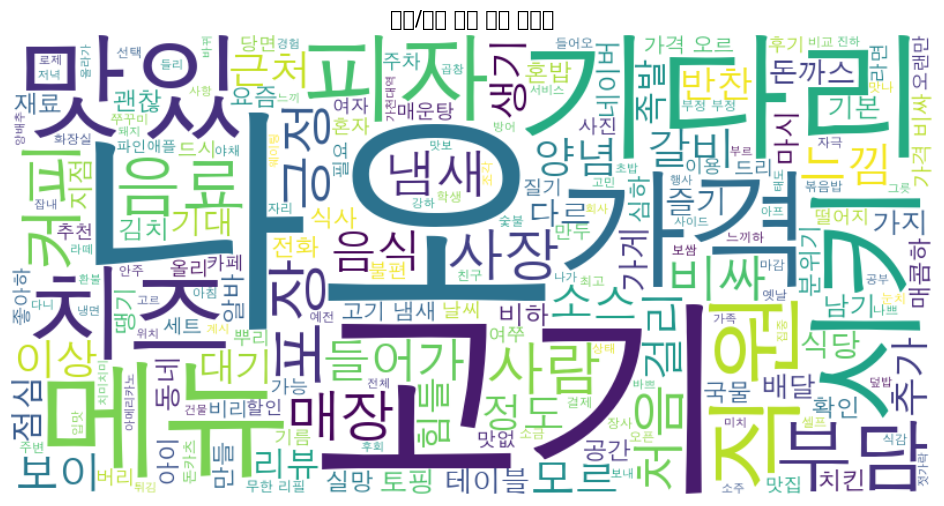

In [80]:
### 부정 리뷰가 많은 식당 10개의 워드클라우드 

# -----------------------------------------------------------------
# PART 1: 데이터 준비 (이전과 동일)
# -----------------------------------------------------------------

if isinstance(df['Review_final'].iloc[0], str):
    df['Review_final'] = df['Review_final'].apply(ast.literal_eval)

negative_df = df[df['Finetuned_Score'] <= 0].copy()
all_negative_words = []
for words in negative_df['Review_final']:
    all_negative_words.extend(words)

# 단어 빈도 계산은 여전히 유용합니다 (결과 확인용)
negative_word_counts = Counter(all_negative_words)
print("--------- 부정/중립 리뷰에서 가장 많이 언급된 단어 TOP 50 ---------")
print(negative_word_counts.most_common(50))

# -----------------------------------------------------------------
# PART 2: 워드 클라우드 생성 (✨✨✨ 핵심 수정 부분 ✨✨✨)
# -----------------------------------------------------------------
# 1. (수정) 단어 리스트를 띄어쓰기로 연결된 '하나의 긴 텍스트'로 변환합니다.
text_for_wordcloud = " ".join(all_negative_words)

# 2. 한글 폰트 경로 설정
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

# 3. (수정) generate_from_frequencies 대신, generate 메소드를 사용합니다.
#    이제 WordCloud가 띄어쓰기를 기준으로 단어를 정확히 인식합니다.
negative_wordcloud = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color='white'
).generate(text_for_wordcloud) # <-- 이 부분이 바뀌었습니다!

# 4. 워드 클라우드를 화면에 보여줍니다.
print("\n--------- (수정 후) 부정/중립 리뷰 워드 클라우드 ---------")
plt.figure(figsize=(12, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('부정/중립 리뷰 핵심 키워드', size=15)
plt.axis('off')
plt.show()

맛 보다는 가격 직원 부담 기다리 의 크기가 큰 걸 보아 
가격과 서비스 문제가 큰 것으로 보임

최종 결론:
"본 프로젝트는 가천대 상권 약 2만 개의 리뷰 데이터를 분석하여, 고객 만족도에 영향을 미치는 핵심 요인을 도출했습니다. KoELECTRA 모델을 파인튜닝하여 리뷰의 긍/부정을 분류한 결과, 전체 리뷰의 약 3.7%에서 부정적인 경험이 나타났습니다."
"특히, 부정 리뷰가 많이 발생한 식당들은 대부분 맛이 표준화된 대형 프랜차이즈였습니다. (이 워드 클라우드를 보여주며) 이들의 부정 리뷰 데이터를 심층 분석한 결과, 고객들의 핵심 불만 사항은 '음식의 맛'이 아닌, '직원 응대'와 같은 서비스 문제, '대기/주차'와 같은 운영 문제, 그리고 '매장 내 냄새'와 같은 환경 문제에 집중되어 있음을 발견했습니다."
"따라서, 가천대 상권의 식당, 특히 프랜차이즈 매장들은 고객 만족도를 높이기 위해 맛의 퀄리티를 유지하는 것과 더불어, 직원 교육 강화, 효율적인 대기 시스템 마련, 매장 환경 개선과 같은 운영 및 서비스 측면의 개선에 더욱 집중해야 할 것입니다. 본 분석 시스템은 이러한 구체적인 개선 포인트를 데이터 기반으로 제시함으로써, 식당 운영의 효율성을 높이는 데 기여할 수 있습니다."


### 점수 만들기

In [398]:
# -----------------------------------------------------------------
# PART 0: 필요한 모든 도구(라이브러리)를 맨 위에 불러옵니다.
# -----------------------------------------------------------------
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time

# -----------------------------------------------------------------
# PART 1: 데이터 로드 및 통합 (리뷰 개수 계산 포함)
# -----------------------------------------------------------------
try:
    # 1. 식당별 속성 점수 요약본을 불러옵니다.
    df_aspect = pd.read_csv("gachon_restaurant_aspect_summary.csv")
    
    # 2. 개별 리뷰 점수 전체 데이터를 불러옵니다.
    df_reviews = pd.read_csv("gachon_reviews_with_final_scores.csv")
except FileNotFoundError as e:
    print(f"오류: 필요한 CSV 파일을 찾을 수 없습니다. ({e.filename})")
    print("파일 이름이 정확한지, 이 코드와 같은 폴더에 있는지 확인해주세요.")
    exit()

# 3. 'Review' 컬럼의 텍스트 길이를 계산하여 'Review_Length' 컬럼을 추가합니다.
df_reviews['Review_Length'] = df_reviews['Review'].astype(str).str.len()

# 4. KoELECTRA 평균 점수를 계산합니다.
df_kobert_mean = df_reviews.groupby('Restaurant')['Finetuned_Score'].mean().reset_index()
df_kobert_mean.rename(columns={'Finetuned_Score': 'KoELECTRA_Avg_Score'}, inplace=True)

# 5. 신뢰도 관련 지표들의 평균을 계산합니다.
trust_cols = ['Revisit_Count', 'Reviewer_Review_Count', 'Review_Length']
df_trust_mean = df_reviews.groupby('Restaurant')[trust_cols].mean().reset_index()
df_trust_mean.rename(columns={
    'Revisit_Count': 'Avg_Revisit', 
    'Reviewer_Review_Count': 'Avg_Reviewer_Level',
    'Review_Length': 'Avg_Review_Length'
}, inplace=True)
    
# 6. 각 식당의 '리뷰 총 개수' 계산
restaurant_counts = df_reviews['Restaurant'].value_counts().reset_index()
restaurant_counts.columns = ['Restaurant', 'Total_Reviews']

# 7. 모든 데이터를 'Restaurant' 이름을 기준으로 하나로 합칩니다.
df_final = pd.merge(df_aspect, df_kobert_mean, on='Restaurant')
df_final = pd.merge(df_final, df_trust_mean, on='Restaurant')
df_final = pd.merge(df_final, restaurant_counts, on='Restaurant')

# 8. 리뷰 개수가 10개 미만인 식당은 분석에서 제외합니다.
MIN_REVIEW_COUNT = 10
original_count = len(df_final)
df_final = df_final[df_final['Total_Reviews'] >= MIN_REVIEW_COUNT].copy()
print(f"리뷰 10개 미만 식당을 제외하여, 분석 대상을 {original_count}개에서 {len(df_final)}개로 조정했습니다.")

# -----------------------------------------------------------------
# PART 2: 스케일링 및 최종 별점 계산
# -----------------------------------------------------------------
scaler_5 = MinMaxScaler(feature_range=(0, 5)) # 5점 만점 스케일러
scaler_1 = MinMaxScaler(feature_range=(0, 1))   # 1점 만점 보너스 스케일러

# 1. 핵심 평점 요소들을 0~10점으로 스케일링합니다.
aspect_cols = ['맛_점수', '가격_점수', '서비스_점수', '분위기_점수']
for col in aspect_cols:
    df_final[f'{col}_scaled'] = scaler_5.fit_transform(df_final[[col]])
df_final['KoELECTRA_Score_scaled'] = scaler_5.fit_transform(df_final[['KoELECTRA_Avg_Score']])
df_final['Rule_Based_Avg_Score'] = df_final[[f'{col}_scaled' for col in aspect_cols]].mean(axis=1)

# 2. 신뢰도 보너스 요소들을 '각각' 0~1 사이로 스케일링합니다.
df_final['Revisit_Bonus'] = scaler_1.fit_transform(df_final[['Avg_Revisit']])
df_final['Reviewer_Level_Bonus'] = scaler_1.fit_transform(df_final[['Avg_Reviewer_Level']])
df_final['Review_Length_Bonus'] = scaler_1.fit_transform(df_final[['Avg_Review_Length']])
df_final['Total_Reviews_log'] = np.log1p(df_final['Total_Reviews'])
df_final['Review_Count_Bonus'] = scaler_1.fit_transform(df_final[['Total_Reviews_log']])

# 3. 가중치를 설정합니다.
# [핵심 평점 가중치]
w_aspect = 0.4
w_kobert = 0.6

# [신뢰도 보너스 가중치] - 각 보너스의 최대 점수를 의미
w_revisit = 0.25      # 최대 0.25점
w_length = 0.10       # 최대 0.1점
w_count = 0.15        # 최대 0.15점

# 4. '인사이트 별점'(보정 전)을 "핵심 평점 + 보너스" 방식으로 계산합니다.
df_final['Core_Rating'] = \
    (df_final['Rule_Based_Avg_Score'] * w_aspect) + \
    (df_final['KoELECTRA_Score_scaled'] * w_kobert)
df_final['Trust_Bonus'] = \
    (df_final['Revisit_Bonus'] * w_revisit) + \
    (df_final['Reviewer_Level_Bonus'] * w_reviewer) + \
    (df_final['Review_Length_Bonus'] * w_length) + \
    (df_final['Review_Count_Bonus'] * w_count)
df_final['Insight_Rating'] = (df_final['Core_Rating'] + df_final['Trust_Bonus']).clip(0, 5)

# 5. '신뢰도 보정(베이즈 평균)'을 적용하여 최종 별점을 계산합니다.
C = df_final['Total_Reviews'].median()
m = df_final['Insight_Rating'].mean()
print(f"\n신뢰도 보정을 위한 기준 리뷰 수(C): {C:.0f}개, 전체 평균 점수(m): {m:.2f}점")
v = df_final['Total_Reviews']
R = df_final['Insight_Rating']
df_final['Final_Rating'] = (v / (v + C)) * R + (C / (v + C)) * m

# -----------------------------------------------------------------
# PART 3: 최종 결과 확인 및 저장
# -----------------------------------------------------------------
final_ranking_cols = [
    'Restaurant', 
    'Final_Rating',
    'Insight_Rating',
    'Total_Reviews',
    '맛_점수_scaled', 
    '가격_점수_scaled', 
    '서비스_점수_scaled', 
    '분위기_점수_scaled'
]
final_ranking = df_final[final_ranking_cols]
final_ranking = final_ranking.sort_values(by='Final_Rating', ascending=False)


final_ranking.to_csv('gachon_final_ranking.csv', index=False, encoding='utf-8-sig')

print(f"\n🎉 5점 만점의 최종 랭킹이 파일에 성공적으로 저장되었습니다!")

print("\n--------- 신뢰도 보정 후 최종 맛집 랭킹 TOP 20 (10점 만점) ---------")
pd.options.display.float_format = '{:.2f}'.format
print(final_ranking.head(20))

리뷰 10개 미만 식당을 제외하여, 분석 대상을 116개에서 106개로 조정했습니다.

신뢰도 보정을 위한 기준 리뷰 수(C): 88개, 전체 평균 점수(m): 3.72점

🎉 5점 만점의 최종 랭킹이 파일에 성공적으로 저장되었습니다!

--------- 신뢰도 보정 후 최종 맛집 랭킹 TOP 20 (10점 만점) ---------
          Restaurant  Final_Rating  Insight_Rating  Total_Reviews  \
111      화리화리 성남가천대점          4.92            5.00           1263   
34       리우차이 성남가천대점          4.84            5.00            610   
63               육연차          4.81            4.96            676   
6             고기로 한끼          4.76            4.83           1198   
110       화로상회 성남복정점          4.70            4.79            963   
7           고기하나 신흥점          4.60            4.71            700   
68       인생극장쪽갈비 성남점          4.53            4.59           1222   
115              회스시          4.52            4.66            505   
10           그날의 분위기          4.48            4.90            159   
72         제순식당 가천대점          4.38            4.64            219   
87              코지가든          4.33            4.60    

저는 리뷰 수가 적은 식당의 평점이 과대/과소평가되는 통계적 왜곡을 방지하기 위해, 리뷰 10개 미만의 식당은 분석 대상에서 제외했습니다. 또한, 나머지 식당들에 대해서는 리뷰 개수에 따라 신뢰도를 보정하는 베이즈 평균 기법을 적용하여, 데이터가 적은 식당의 평점은 전체 평균에 가깝게, 데이터가 많은 식당의 평점은 자체 평점을 신뢰하도록 설계했습니다. 이를 통해 통계적 안정성과 신뢰도를 모두 확보한 최종 맛집 랭킹을 도출할 수 있었습니다."

In [392]:
df

,Restaurant,맛_점수,가격_점수,서비스_점수,분위기_점수,Total_Reviews,Final_Rating
0,1209 가천대점,4.65,3.96,4.19,3.61,28.00,4.80
1,BHC치킨 태평역점,3.82,2.08,4.26,2.50,49.00,4.80
2,VVCZ,4.82,4.42,4.73,4.11,183.00,4.78
3,가천대학교 교육대학원지점,2.81,2.92,3.21,2.50,30.00,4.77
4,가천한마당,4.72,2.92,4.34,2.50,56.00,4.76
...,...,...,...,...,...,...,...
111,화리화리 성남가천대점,4.98,4.36,4.95,4.85,1263.00,2.84
112,황궁쟁반짜장 태평점,3.21,2.50,2.50,2.50,1.00,2.68
113,황궁짜장,4.22,3.61,3.86,2.50,41.00,2.68
114,황씨네대구탕,4.38,2.50,3.21,2.50,29.00,2.60


최종 통계량 심층 분석: 숫자가 말해주는 것들
count: 106.00
해석: "총 117개의 식당 중, 통계적 신뢰도를 확보하기 위해 리뷰가 10개 이상인 106곳만을 최종 분석 대상으로 선정했습니다."
의미: 분석의 신뢰도를 높이기 위해 스스로 기준을 세우고 데이터를 필터링했다는, 분석가로서의 주도성을 보여줍니다.
mean: 2.87 / 50% (median): 2.91
해석: "제가 개발한 별점 시스템에 따르면, 가천대 상권의 '평균적인 맛집'은 5점 만점에 약 2.9점 수준입니다."
의미: 대부분의 식당은 '평균' 수준에 몰려있으며, 이는 상권이 전반적으로 상향 평준화되었거나, 반대로 아주 특별한 맛집을 찾기는 어려운 시장일 수 있음을 시사합니다.
std (표준편차): 0.39
해석: "식당 간의 점수 편차는 0.39점으로 비교적 작게 나타났습니다."
의미: 식당들의 점수가 평균(2.9점) 근처에 촘촘하게 모여있다는 뜻입니다. 이는 식당 간의 경쟁이 매우 치열하다는 것을 보여주는 강력한 증거입니다.
min: 2.03 / max: 3.98
해석: "가장 높은 점수를 받은 식당도 5점 만점이 아닌 3.98점을 기록했습니다."
의미: 이것이 바로 서영님 모델의 **'객관성'**을 증명하는 가장 중요한 지표입니다! "제 모델은 단순히 긍정 리뷰만 많다고 해서 5점 만점을 주지 않습니다. 리뷰의 신뢰도, 부정 리뷰의 존재 여부 등을 모두 고려하여 점수를 '보정'하기 때문에, 보다 현실적인 점수 분포를 보입니다." 라고 자신있게 말할 수 있습니다.
25%: 2.65 / 75%: 3.10
해석: "이 상권에서 '상위 25% 맛집'으로 인정받으려면, 최소 3.10점 이상을 받아야 하며, 하위 25%는 2.65점 이하로 나타났습니다."
의미: 이 점수를 기준으로, "추천 맛집 그룹", "평범한 맛집 그룹", "개선 필요 맛집 그룹"으로 식당을 객관적으로 세분화할 수 있는 기준점을 마련했습니다.


최종 결론 및 비즈니스 제언
본 프로젝트는 약 2만 개의 리뷰 데이터를 기반으로, 가천대 상권의 식당들을 다각적으로 평가하는 새로운 별점 시스템을 구축했습니다.
시장 특성: 제가 개발한 '신뢰도 보정 별점'에 따르면, 가천대 상권의 평균 점수는 2.91점(5점 만점)이며, 표준편차는 0.39로 식당 간의 편차가 크지 않은 경쟁이 치열하고 상향 평준화된 시장으로 분석됩니다.
핵심 성공/실패 요인: 파인튜닝된 KoELECTRA 모델을 통해 부정 리뷰를 분석한 결과, 고객 불만은 '음식의 맛' 자체보다는 **'서비스 응대', '매장 환경(냄새, 공간)', '운영(대기, 주차)'**과 같은 비음식적 요인에서 비롯되는 경우가 훨씬 많다는 핵심 인사이트를 발견했습니다.
최종 랭킹의 가치: 본 프로젝트에서 개발한 최종 별점(Final_Rating)은 단순히 리뷰의 감성뿐만 아니라, **리뷰의 개수(신뢰도), 재방문 여부(충성도), 리뷰어의 전문성(신뢰도)**까지 종합적으로 고려한 지표입니다. 이를 통해, 리뷰가 적은 신생 맛집의 잠재력을 평가하고, 리뷰가 많지만 부정적 경험이 누적된 식당의 위험 신호를 감지하는 등, 기존 별점 시스템보다 훨씬 더 객관적이고 안정적인 평가가 가능합니다.
제언: 따라서 가천대 상권에서 성공하기 위해서는, 맛의 퀄리티를 유지하는 것을 넘어, 직원 교육을 통한 서비스 품질 향상과 효율적인 대기 시스템 마련 등 운영 효율성을 높이는 것이 핵심적인 성공 전략이 될 수 있습니다.

In [400]:
# CODE CELL: 데이터 병합
import pandas as pd

# -----------------------------------------------------------------
# PART 1: 데이터 불러오기
# -----------------------------------------------------------------
# 파일 이름을 변수로 지정하여 관리하면 편리합니다.
ASPECT_SUMMARY_FILE = "gachon_final_ranking.csv"
CATEGORIES_FILE = "gachon_restaurant_categories.csv"

try:
    # 1. 식당별 속성 점수 데이터를 불러옵니다.
    df_aspect = pd.read_csv(ASPECT_SUMMARY_FILE)
    
    # 2. 식당별 카테고리 데이터를 불러옵니다.
    df_category = pd.read_csv(CATEGORIES_FILE)
except FileNotFoundError as e:
    print(f"오류: 필요한 CSV 파일을 찾을 수 없습니다. ({e.filename})")
    print("두 파일이 이 코드와 같은 폴더에 있는지 확인해주세요.")
    exit()

print("--------- 속성 점수 데이터 (상위 5개) ---------")
print(df_aspect.head())
print("\n--------- 카테고리 데이터 (상위 5개) ---------")
print(df_category.head())


# -----------------------------------------------------------------
# PART 2: 두 데이터 합치기 (Merge)
# -----------------------------------------------------------------
# 'Restaurant' 컬럼을 기준으로 두 데이터프레임을 합칩니다.
# how='left'는 df_aspect(왼쪽)의 모든 식당은 유지하되, df_category(오른쪽)에서 일치하는 카테고리 정보를 가져와 붙이라는 의미입니다.
summary_with_category_df = pd.merge(df_aspect, df_category, on='Restaurant', how='left')


# -----------------------------------------------------------------
# PART 3: 결과 확인 및 저장|
# -----------------------------------------------------------------
print("\n--------- 병합 완료된 데이터 (상위 5개) ---------")
# 'Category' 컬럼이 맨 오른쪽에 잘 추가되었는지 확인합니다.
print(summary_with_category_df.head())

# 최종 결과 파일을 저장합니다.
OUTPUT_FILE = "gachon_final_summary_with_category.csv"
summary_with_category_df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')

print(f"\n🎉 모든 정보가 합쳐진 최종 요약 파일이 '{OUTPUT_FILE}'(으)로 저장되었습니다!")

--------- 속성 점수 데이터 (상위 5개) ---------
    Restaurant  Final_Rating  Insight_Rating  Total_Reviews  맛_점수_scaled  \
0  화리화리 성남가천대점          4.92            5.00           1263         5.00   
1  리우차이 성남가천대점          4.84            5.00            610         4.86   
2          육연차          4.81            4.96            676         4.97   
3       고기로 한끼          4.76            4.83           1198         4.93   
4   화로상회 성남복정점          4.70            4.79            963         4.95   

   가격_점수_scaled  서비스_점수_scaled  분위기_점수_scaled  
0          4.31           4.96           5.00  
1          4.50           5.00           4.96  
2          4.76           4.80           4.51  
3          4.73           4.94           4.69  
4          4.72           4.92           4.40  

--------- 카테고리 데이터 (상위 5개) ---------
    Restaurant Category
0          회스시      일식당
1  인생극장쪽갈비 성남점   돼지고기구이
2  화리화리 성남가천대점    주꾸미요리
3   화로상회 성남복정점     고기뷔페
4       하노이쌀국수    베트남음식

--------- 병합 완료된 데이터 (상위 5개) -----

In [402]:
df = pd.read_csv('gachon_final_summary_with_category.csv')

### 최종 데이터

In [404]:
df

,Restaurant,Final_Rating,Insight_Rating,Total_Reviews,맛_점수_scaled,가격_점수_scaled,서비스_점수_scaled,분위기_점수_scaled,Category
0,화리화리 성남가천대점,4.92,5.00,1263,5.00,4.31,4.96,5.00,주꾸미요리
1,리우차이 성남가천대점,4.84,5.00,610,4.86,4.50,5.00,4.96,중식당
2,육연차,4.81,4.96,676,4.97,4.76,4.80,4.51,덮밥
3,고기로 한끼,4.76,4.83,1198,4.93,4.73,4.94,4.69,한식
4,화로상회 성남복정점,4.70,4.79,963,4.95,4.72,4.92,4.40,고기뷔페
...,...,...,...,...,...,...,...,...,...
101,겐코쇼쿠도 복정점,3.15,2.89,188,4.29,0.00,4.02,1.18,일식당
102,바다횟집,3.09,1.46,34,3.89,2.42,2.77,0.00,생선회
103,피자스쿨 성남태평점,3.07,1.04,28,2.36,1.24,0.00,0.89,피자
104,두찜 성남태평점,2.92,2.28,111,4.54,1.24,2.77,0.00,찜닭


In [144]:

df[df['Category'] == '카페'].sort_values(by='Final_Rating', ascending=False)



,Restaurant,Final_Rating,Insight_Rating,Total_Reviews,맛_점수_scaled,가격_점수_scaled,서비스_점수_scaled,분위기_점수_scaled,Category
82,컴포즈커피 가천대학점,2.61,2.55,407,0.58,1.50,0.66,0.08,카페
85,투썸플레이스 가천대점,2.51,2.19,97,0.24,0.05,0.69,0.20,카페
94,이디야커피 가천대점,2.34,2.09,182,0.30,0.24,0.42,0.12,카페
100,파스쿠찌 가천대점,2.17,1.96,294,0.32,0.00,0.69,0.31,카페
102,스타벅스 가천대학교점,2.16,1.81,174,0.41,0.08,0.72,0.26,카페
105,메가MGC커피 가천대역점,2.03,1.55,155,0.43,0.57,0.45,0.17,카페


In [406]:
# CODE CELL: 카테고리 재분류 (최종 완성판)


# 2. 서영님의 새로운 기준과 발견된 카테고리를 모두 포함한 '재매핑 규칙'을 정의합니다.
category_map = {
    # 한식
    '감자탕': '한식', '고기뷔페': '한식', '곰탕,설렁탕': '한식', '곱창,막창,양': '한식',
    '국수': '한식', '김밥': '한식', '닭볶음탕': '한식', '덮밥': '한식',
    '돼지고기구이': '한식', '백반,가정식': '한식', '순대,순댓국': '한식',
    '육류,고기요리': '한식', '족발,보쌈': '한식', '주꾸미요리': '한식',
    '정육식당': '한식', '찜닭': '한식', '분식': '한식', '종합분식': '한식',
    '도시락,컵밥': '한식', '아귀찜,해물찜': '한식', '한식': '한식', '찌개,전골': '한식',
    '해물,생선요리': '한식', '한식뷔페': '한식',

    # 중식
    '중식당': '중식',

    # 일식
    '일식당': '일식', '일식튀김,꼬치': '일식', '우동,소바': '일식', '생선회': '일식',
    '돈가스': '일식',

    # 양식/기타 국가
    '양식': '양식', '스파게티,파스타전문': '양식', '멕시코,남미음식': '기타',
    '베트남음식': '기타', '인도음식': '기타', '퓨전음식': '기타',

    # 패스트푸드
    '피자': '패스트푸드', '치킨,닭강정': '패스트푸드', '햄버거': '패스트푸드',
    '토스트': '패스트푸드', '후렌치후라이': '패스트푸드',
    
    # 카페/디저트
    '카페,디저트': '카페/디저트', '도넛': '카페/디저트', '베이커리': '카페/디저트', 
    '아이스크림': '카페/디저트', '테이크아웃커피': '카페/디저트', '케이크전문': '카페/디저트',
    '차': '카페/디저트', '카페': '카페/디저트',

    # 주점/기타
    '맥주,호프': '기타', '요리주점': '기타', '전통,민속주점': '기타', '포장마차': '기타'
}

# 3. 'Category' 컬럼에 map 함수를 적용하여, 'Category_Group'이라는 새로운 대분류 컬럼을 만듭니다.
df['Category_Group'] = df['Category'].map(category_map)

# 4. 혹시라도 또 매핑되지 않은 카테고리가 있는지 최종 확인합니다.
unmapped_count = df['Category_Group'].isnull().sum()
if unmapped_count > 0:
    unmapped_list = df[df['Category_Group'].isnull()]['Category'].unique()
    print(f"경고: {unmapped_count}개의 행이 매핑되지 않았습니다. -> {unmapped_list}")
    # 매핑되지 않은 값은 '기타'로 채워줍니다.
    df['Category_Group'].fillna('기타', inplace=True)

print("\n--------- 카테고리 재분류 완료 (샘플 확인) ---------")
print(df[['Restaurant', 'Category', 'Category_Group']].sample(10)) # 랜덤으로 10개 확인


# 5. 이제 새로운 대분류('Category_Group')를 기준으로, 각 속성 점수의 평균을 다시 계산합니다.
category_group_scores = df.groupby('Category_Group')[['Final_Rating','맛_점수_scaled', '가격_점수_scaled', '서비스_점수_scaled', '분위기_점수_scaled']].mean()

print("\n--------- 최종 대분류 카테고리별 평균 속성 점수 ---------")
pd.options.display.float_format = '{:.2f}'.format
# '맛_점수'가 높은 순으로 정렬하여 출력합니다.
print(category_group_scores.sort_values(by='맛_점수_scaled', ascending=False))


--------- 카테고리 재분류 완료 (샘플 확인) ---------
      Restaurant Category Category_Group
26  파리바게뜨 태평오거리점     베이커리         카페/디저트
89          민속식당       한식             한식
58   행복은간장밥 가천대점       한식             한식
70        행복한식부페     한식뷔페             한식
10          코지가든   카페,디저트         카페/디저트
0    화리화리 성남가천대점    주꾸미요리             한식
65      카페천국 성남점   카페,디저트         카페/디저트
4     화로상회 성남복정점     고기뷔페             한식
64        황씨네대구탕  해물,생선요리             한식
42    완미족발 성남태평점    족발,보쌈             한식

--------- 최종 대분류 카테고리별 평균 속성 점수 ---------
                Final_Rating  맛_점수_scaled  가격_점수_scaled  서비스_점수_scaled  \
Category_Group                                                           
양식                      4.16         4.57          2.29           4.19   
일식                      3.75         4.40          2.71           3.77   
한식                      3.86         4.21          2.81           3.57   
카페/디저트                  3.75         4.11          2.19           3.95   
중식                   

#### 이제 해야할것 
최종 랭킹 표: final_ranking.head(20) 결과물.
카테고리별 분석 표: 우리가 만들었던 '최종 대분류 카테고리별 평균 속성 점수' 표.
핵심 인사이트 시각화 자료:
전체 리뷰 워드 클라우드 vs. 부정 리뷰 워드 클라우드 (강력한 대비 효과!)
Top 3 식당의 레이더 차트 (강점과 약점을 시각적으로 보여줌)
최종 별점 분포 히스토그램 (전체 시장의 특징을 보여줌)


In [408]:
 # 최종 랭킹 표 : 
df.head(10)

,Restaurant,Final_Rating,Insight_Rating,Total_Reviews,맛_점수_scaled,가격_점수_scaled,서비스_점수_scaled,분위기_점수_scaled,Category,Category_Group
0,화리화리 성남가천대점,4.92,5.00,1263,5.00,4.31,4.96,5.00,주꾸미요리,한식
1,리우차이 성남가천대점,4.84,5.00,610,4.86,4.50,5.00,4.96,중식당,중식
2,육연차,4.81,4.96,676,4.97,4.76,4.80,4.51,덮밥,한식
3,고기로 한끼,4.76,4.83,1198,4.93,4.73,4.94,4.69,한식,한식
4,화로상회 성남복정점,4.70,4.79,963,4.95,4.72,4.92,4.40,고기뷔페,한식
5,고기하나 신흥점,4.60,4.71,700,4.88,3.60,4.96,4.84,"육류,고기요리",한식
6,인생극장쪽갈비 성남점,4.53,4.59,1222,4.92,2.50,4.88,4.16,돼지고기구이,한식
7,회스시,4.52,4.66,505,4.86,4.19,4.90,4.88,일식당,일식
8,그날의 분위기,4.48,4.90,159,4.87,2.82,4.80,4.87,양식,양식
9,제순식당 가천대점,4.38,4.64,219,4.88,4.86,3.97,4.25,"백반,가정식",한식


In [410]:
# 카테고리별 분석표 
category_group_scores

,Final_Rating,맛_점수_scaled,가격_점수_scaled,서비스_점수_scaled,분위기_점수_scaled
Category_Group,,,,,
기타,3.93,4.01,2.76,3.46,2.11
양식,4.16,4.57,2.29,4.19,4.20
일식,3.75,4.40,2.71,3.77,1.66
중식,3.79,4.07,2.30,3.20,2.03
카페/디저트,3.75,4.11,2.19,3.95,2.27
패스트푸드,3.67,3.95,2.52,3.10,1.36
한식,3.86,4.21,2.81,3.57,2.18


In [412]:
# CODE CELL 1: 기본 설정 및 데이터 로드
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import ast

# --- (중요!) Matplotlib 한글 폰트 설정 ---
# Mac 사용자
plt.rcParams['font.family'] = 'AppleGothic'
# Windows 사용자
# plt.rcParams['font.family'] = 'Malgun Gothic'

# ------------------------------------------------
# --- 데이터 파일 이름 (실제 파일명으로 수정!) ---
PREPROCESSED_FILE = "gachon_restaurant_koelectra_summary.csv"
FINAL_RANKING_FILE = "gachon_final_summary_with_category.csv" # <--- 이 부분의 날짜/시간을 실제 파일명으로 바꿔주세요
# ------------------------------------------------

try:
    # 1. 워드 클라우드를 위한 상세 리뷰 데이터를 불러옵니다.
    df_reviews = pd.read_csv(PREPROCESSED_FILE)
    if isinstance(df_reviews['Review_final'].iloc[0], str):
        df_reviews['Review_final'] = df_reviews['Review_final'].apply(ast.literal_eval)

    # 2. 레이더 차트와 히스토그램을 위한 최종 랭킹 데이터를 불러옵니다.
    df_ranking = pd.read_csv(FINAL_RANKING_FILE)
    
except FileNotFoundError as e:
    print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다. 파일 이름을 확인해주세요.")
    # exit() # 오류 발생 시 중단
    
print("데이터 로딩 완료! 시각화를 시작합니다.")

데이터 로딩 완료! 시각화를 시작합니다.


In [258]:
from PIL import Image
import matplotlib.cm as cm
import random
from collections import Counter

img = Image.open('star_mask.png').convert("RGBA")
data = np.array(img)

mask_data = 255 * (data[..., 3] == 0).astype(np.uint8) \
            + data[..., :3].sum(axis=2) * (data[..., 3] != 0).astype(np.uint8) / 3

star_mask = mask_data.astype(np.uint8)


print("\n[시각화 1] 워드 클라우드를 생성합니다...")
all_words = " ".join([" ".join(words) for words in df_reviews['Review_final']])
negative_words_only = " ".join([" ".join(words) for words in df_reviews[df_reviews['Sentiment_Label'] == '부정']['Review_final']])
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'


# ★★★★★★★★★★★★ 핵심 수정 사항 1: 단어 빈도수 직접 계산 ★★★★★★★★★★★★
# 1-1. 전체 리뷰와 부정 리뷰의 단어들을 각각 하나의 리스트로 합칩니다.
all_word_list = [word for sublist in df_reviews['Review_final'] for word in sublist]
negative_word_list = [word for sublist in df_reviews[df_reviews['Sentiment_Label'] == '부정']['Review_final'] for word in sublist]

# 1-2. Counter를 이용해 각 단어의 빈도수를 계산합니다.
# 결과: {'맛있': 3, '새우': 2, ...} 와 같은 딕셔너리 형태가 됩니다.
all_word_counts = Counter(all_word_list)
negative_word_counts = Counter(negative_word_list)
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

# ★★★★★★★★★★★★ 이 부분이 핵심입니다 ★★★★★★★★★★★★
# (2) 워드클라우드에서 제외할 단어(불용어) 목록을 정의합니다.
# 여기에 원치 않는 단어를 자유롭게 추가하거나 제거할 수 있습니다.
custom_stopwords = ['고기', '치즈', '주문', '방문', '추가', '메뉴', '긍정','나오','갈비','쭈꾸미','피자','커피']
stopwords_set = set(custom_stopwords) # 리스트보다 세트(set)가 처리 속도가 더 빠릅니다.
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


# ★★★★★★★★★★★★ 핵심 수정 사항 2: 가독성을 위한 색상 함수 (유지) ★★★★★★★★★★★
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    cmap = cm.get_cmap('Reds')
    # 0.4로 설정하여 너무 연한 색은 선택되지 않도록 함
    return "rgba" + str(cmap(random.uniform(0.4, 1.0), bytes=True))
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


# ★★★★★★★★★★★★ 핵심 수정 사항 2: 불용어 제거 및 generate_from_frequencies 사용 ★★★★★★★★★★★★
# 2-1. 계산된 빈도수 딕셔너리에서 불용어를 제거합니다.
filtered_all_counts = {word: count for word, count in all_word_counts.items() if word not in stopwords_set}
filtered_negative_counts = {word: count for word, count in negative_word_counts.items() if word not in stopwords_set}

# 2-2. 워드클라우드 객체를 생성합니다.
wc_all = WordCloud(font_path=font_path, width=800, height=800, background_color='white', mask=star_mask, colormap='viridis')
wc_neg = WordCloud(font_path=font_path, width=800, height=800, background_color='white', mask=star_mask, color_func=red_color_func)

# 2-3. generate 대신 generate_from_frequencies 메소드를 사용합니다.
wc_all.generate_from_frequencies(filtered_all_counts)
wc_neg.generate_from_frequencies(filtered_negative_counts)





# 2-1. 전체 리뷰 워드클라우드 저장
fig_all = plt.figure(figsize=(10, 10))
plt.imshow(wc_all, interpolation='bilinear')
plt.axis('off')
# plt.show() 대신 savefig 사용
plt.savefig('wordcloud_all_reviews.png',  # 파일 이름
            transparent=True,             # 배경을 투명하게
            dpi=300,                      # 고화질(해상도)로 저장
            bbox_inches='tight',          # 불필요한 여백 제거
            pad_inches=0)                 # 여백 0으로 설정
print("'wordcloud_all_reviews.png' (전체 리뷰) 파일이 저장되었습니다.")
plt.close(fig_all) # 메모리 관리를 위해 Figure 닫기


# 2-2. 부정 리뷰 워드클라우드 저장
fig_neg = plt.figure(figsize=(10, 10))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud_negative_reviews.png',
            transparent=True,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)
print("'wordcloud_negative_reviews.png' (부정 리뷰) 파일이 저장되었습니다.")
plt.close(fig_neg)
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


[시각화 1] 워드 클라우드를 생성합니다...


/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1510/630676099.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


'wordcloud_all_reviews.png' (전체 리뷰) 파일이 저장되었습니다.
'wordcloud_negative_reviews.png' (부정 리뷰) 파일이 저장되었습니다.


'final_rating_minimal.png' 파일이 성공적으로 저장되었습니다.


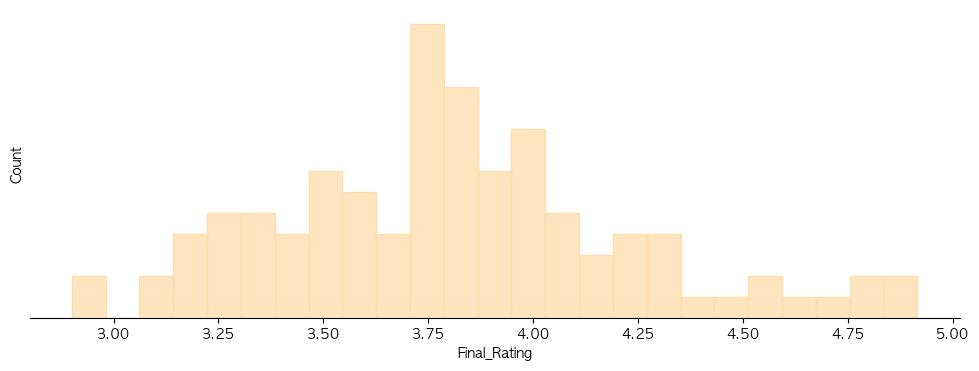


--------- Final_Rating 기초 통계량 ---------
count   106.00
mean      3.81
std       0.42
min       2.90
25%       3.53
50%       3.79
75%       4.02
max       4.92
Name: Final_Rating, dtype: float64


In [416]:
plt.figure(figsize=(12, 4)) # 가로로 길고 세로는 짧게 비율 조정

pastel_yellow = '#FFDDAA'
sns.histplot(data=df, x='Final_Rating', bins=25, kde=False,
             color=pastel_yellow, edgecolor=pastel_yellow)

# ★★★★★★★★★★★★ 핵심 수정 사항 ★★★★★★★★★★★★
# 2-1. 제목과 y축 레이블을 삭제합니다. (해당 라인을 주석 처리 또는 삭제)
# plt.title('최종 신뢰도 보정 별점 (Final_Rating) 분포', size=18, pad=15)
# plt.ylabel('식당 수', size=12)

# 2-2. y축의 눈금(숫자)을 없앱니다.
plt.yticks([])

# 2-3. 그래프의 테두리(spines)를 제어합니다.
ax = plt.gca() # gca = get current axes, 현재 축 정보를 가져옴
ax.spines['top'].set_visible(False)    # 위쪽 테두리 숨기기
ax.spines['right'].set_visible(False)   # 오른쪽 테두리 숨기기
ax.spines['left'].set_visible(False)    # 왼쪽 테두리 숨기기
# ax.spines['bottom']은 x축이므로 남겨둡니다.
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


# plt.xlim(0, 5)

# 4. 저장하고 화면에 보여줍니다. (순서 중요!)
plt.savefig('final_rating_minimal.png',
            transparent=True,
            dpi=300,
            bbox_inches='tight', # 불필요한 여백 제거
            pad_inches=0.1)    # 약간의 여백은 남겨둠

print("'final_rating_minimal.png' 파일이 성공적으로 저장되었습니다.")
plt.show()


# 5. 기초 통계량 출력
print("\n--------- Final_Rating 기초 통계량 ---------")
pd.options.display.float_format = '{:.2f}'.format
print(df['Final_Rating'].describe())


--------- 👑 최종 랭킹 TOP 3 식당 강점/약점 분석 👑 ---------

--- <화리화리 성남가천대점>의 스케일링된 속성 점수 ---
   맛_점수_scaled  가격_점수_scaled  서비스_점수_scaled  분위기_점수_scaled
0         5.00          4.31           4.96           5.00


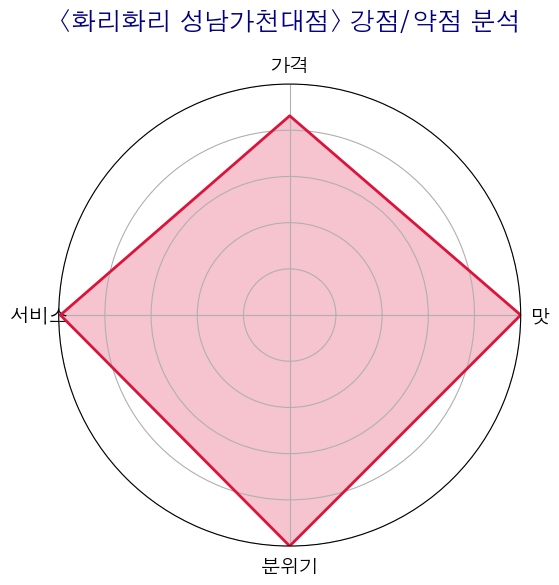


--- <리우차이 성남가천대점>의 스케일링된 속성 점수 ---
   맛_점수_scaled  가격_점수_scaled  서비스_점수_scaled  분위기_점수_scaled
1         4.86          4.50           5.00           4.96


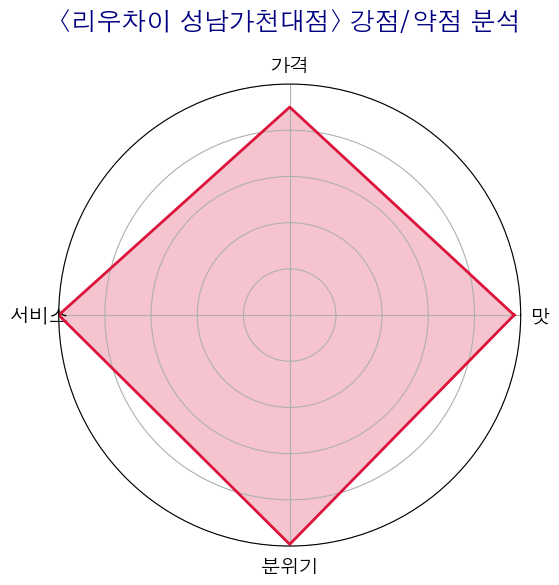


--- <육연차>의 스케일링된 속성 점수 ---
   맛_점수_scaled  가격_점수_scaled  서비스_점수_scaled  분위기_점수_scaled
2         4.97          4.76           4.80           4.51


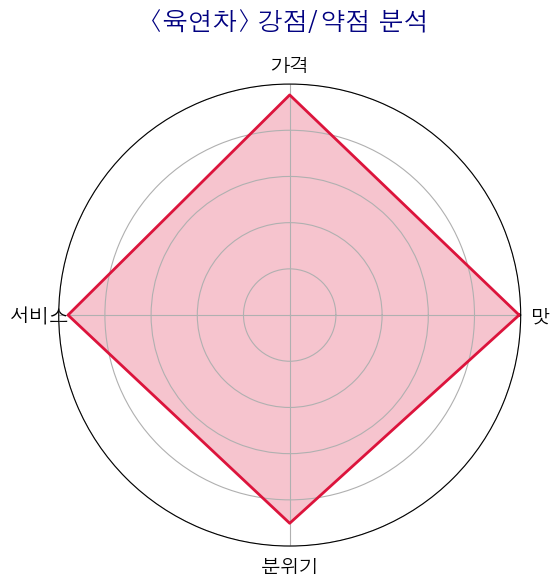

In [418]:
# CODE CELL 3: TOP 3 식당 레이더 차트


# 1. 레이더 차트를 그리는 함수 (이전과 동일)
def plot_radar_chart(df, restaurant_name):
    score_cols = ['맛_점수_scaled', '가격_점수_scaled', '서비스_점수_scaled', '분위기_점수_scaled']
    labels = [col.replace('_점수_scaled', '') for col in score_cols]
    num_vars = len(labels)
    
    try:
        values = df[df['Restaurant'] == restaurant_name][score_cols].iloc[0].values.flatten().tolist()
    except IndexError:
        print(f"오류: '{restaurant_name}' 식당을 찾을 수 없습니다.")
        return

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color='crimson', linewidth=2)
    ax.fill(angles, values, color='crimson', alpha=0.25)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=14)
    ax.set_ylim(0, 5) # 10점 만점으로 축 범위 고정
    plt.title(f"<{restaurant_name}> 강점/약점 분석", size=18, color='navy', y=1.1)
    plt.show()

# 2. 최종 랭킹에서 TOP 3 식당의 이름을 가져옵니다.
top_3_restaurants = df_ranking['Restaurant'].head(3).tolist()


# 3. 각 식당에 대해 레이더 차트를 그립니다.
print("\n--------- 👑 최종 랭킹 TOP 3 식당 강점/약점 분석 👑 ---------")

# 3. 각 식당에 대해, '데이터를 먼저 출력'하고 나서 레이더 차트를 그립니다.
for restaurant_name in top_3_restaurants:
    
    # --- ✨✨✨ 여기가 추가된 부분! (데이터 확인) ✨✨✨ ---
    print(f"\n--- <{restaurant_name}>의 스케일링된 속성 점수 ---")
    
    # 시각화에 사용할 데이터만 필터링해서 보기 좋게 출력합니다.
    restaurant_data = df_ranking[df_ranking['Restaurant'] == restaurant_name][
        ['맛_점수_scaled', '가격_점수_scaled', '서비스_점수_scaled', '분위기_점수_scaled']
    ]
    print(restaurant_data)
    # # -----------------------------------------------------

    # # 이제 이 데이터를 바탕으로 레이더 차트를 그립니다.
    plot_radar_chart(df_ranking, restaurant_name)


--- 👑 TOP 1 (화리화리 성남가천대점) vs BOTTOM 1 (가천대학교 교육대학원지점) 비교 분석 👑 ---


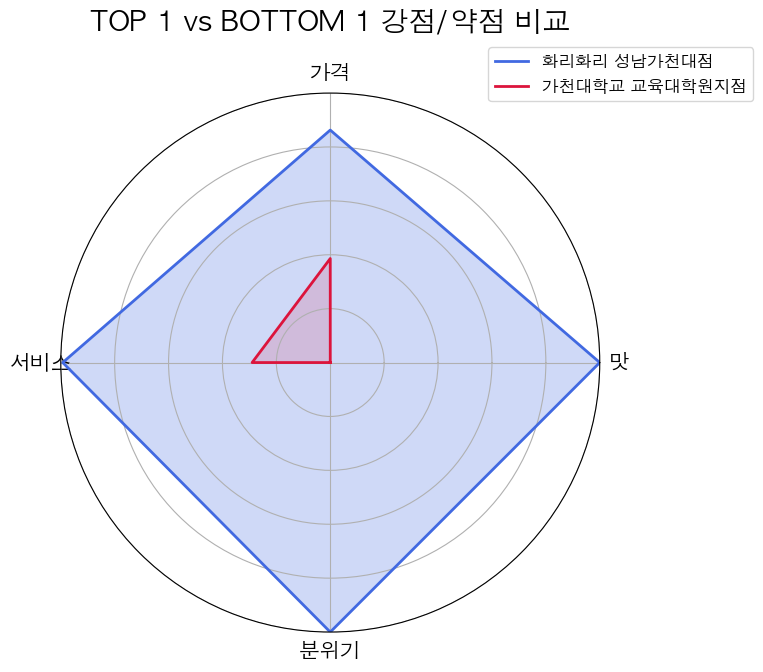

In [420]:



# ★★★★★★★★★★★★ 핵심 수정 사항 1: 비교 차트를 그리는 새로운 함수 ★★★★★★★★★★★★
def plot_comparative_radar_chart(df, top_restaurant, bottom_restaurant):
    score_cols = ['맛_점수_scaled', '가격_점수_scaled', '서비스_점수_scaled', '분위기_점수_scaled']
    labels = [col.replace('_점수_scaled', '') for col in score_cols]
    num_vars = len(labels)

    # 각도를 계산합니다 (이 부분은 동일).
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] # 차트를 닫기 위해 첫 번째 각도를 마지막에 추가

    # Figure와 축을 준비합니다.
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    # --- TOP 1 식당 데이터 준비 및 그리기 ---
    try:
        top_values = df[df['Restaurant'] == top_restaurant][score_cols].iloc[0].tolist()
        top_values += top_values[:1] # 차트를 닫기 위해 첫 번째 값을 마지막에 추가
        # 파란색 계열로 TOP 1을 그립니다.
        ax.plot(angles, top_values, color='royalblue', linewidth=2, linestyle='solid', label=top_restaurant)
        ax.fill(angles, top_values, 'royalblue', alpha=0.25)
    except IndexError:
        print(f"오류: TOP 1 식당 '{top_restaurant}'을(를) 찾을 수 없습니다.")
        return

    # --- BOTTOM 1 식당 데이터 준비 및 그리기 ---
    try:
        bottom_values = df[df['Restaurant'] == bottom_restaurant][score_cols].iloc[0].tolist()
        bottom_values += bottom_values[:1]
        # 붉은색 계열로 BOTTOM 1을 그립니다.
        ax.plot(angles, bottom_values, color='crimson', linewidth=2, linestyle='solid', label=bottom_restaurant)
        ax.fill(angles, bottom_values, 'crimson', alpha=0.15)
    except IndexError:
        print(f"오류: BOTTOM 1 식당 '{bottom_restaurant}'을(를) 찾을 수 없습니다.")
        return

    # --- 차트 최종 꾸미기 ---
    ax.set_yticklabels([]) # y축 숫자 라벨은 숨깁니다.
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=15)
    ax.set_ylim(0, 5) # 5점 만점으로 축 범위 고정

    plt.title('TOP 1 vs BOTTOM 1 강점/약점 비교', size=20, color='black', y=1.1)
    
    # 범례(Legend)를 추가하여 어떤 색이 어떤 식당인지 표시합니다.
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
    
    plt.show()

# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

# 2. 최종 랭킹에서 TOP 1과 BOTTOM 1 식당의 이름을 가져옵니다.
# .iloc[0]는 첫 번째 행, .iloc[-1]은 마지막 행을 의미합니다.
top_1_restaurant = df_ranking['Restaurant'].iloc[0]
bottom_1_restaurant = df_ranking['Restaurant'].iloc[-1]

# 3. 새로운 함수를 호출하여 비교 레이더 차트를 그립니다.
print(f"\n--- 👑 TOP 1 ({top_1_restaurant}) vs BOTTOM 1 ({bottom_1_restaurant}) 비교 분석 👑 ---")
plot_comparative_radar_chart(df_ranking, top_1_restaurant, bottom_1_restaurant)

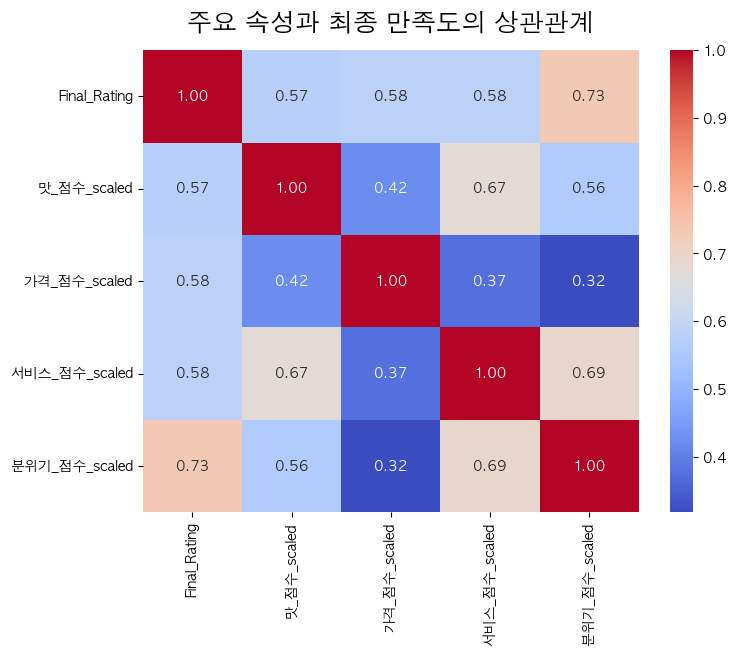

In [422]:
import seaborn as sns
import matplotlib.pyplot as plt

# df_ranking_new 에서 상관관계를 분석할 컬럼들만 선택합니다.
corr_df = df[['Final_Rating', '맛_점수_scaled', '가격_점수_scaled', '서비스_점수_scaled', '분위기_점수_scaled']]

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_df.corr(), 
    annot=True,     # 각 칸에 숫자 표시
    cmap='coolwarm',# 색상 테마
    fmt='.2f'       # 소수점 둘째 자리까지 표시
)
plt.title('주요 속성과 최종 만족도의 상관관계', size=18, pad=15)
plt.show()

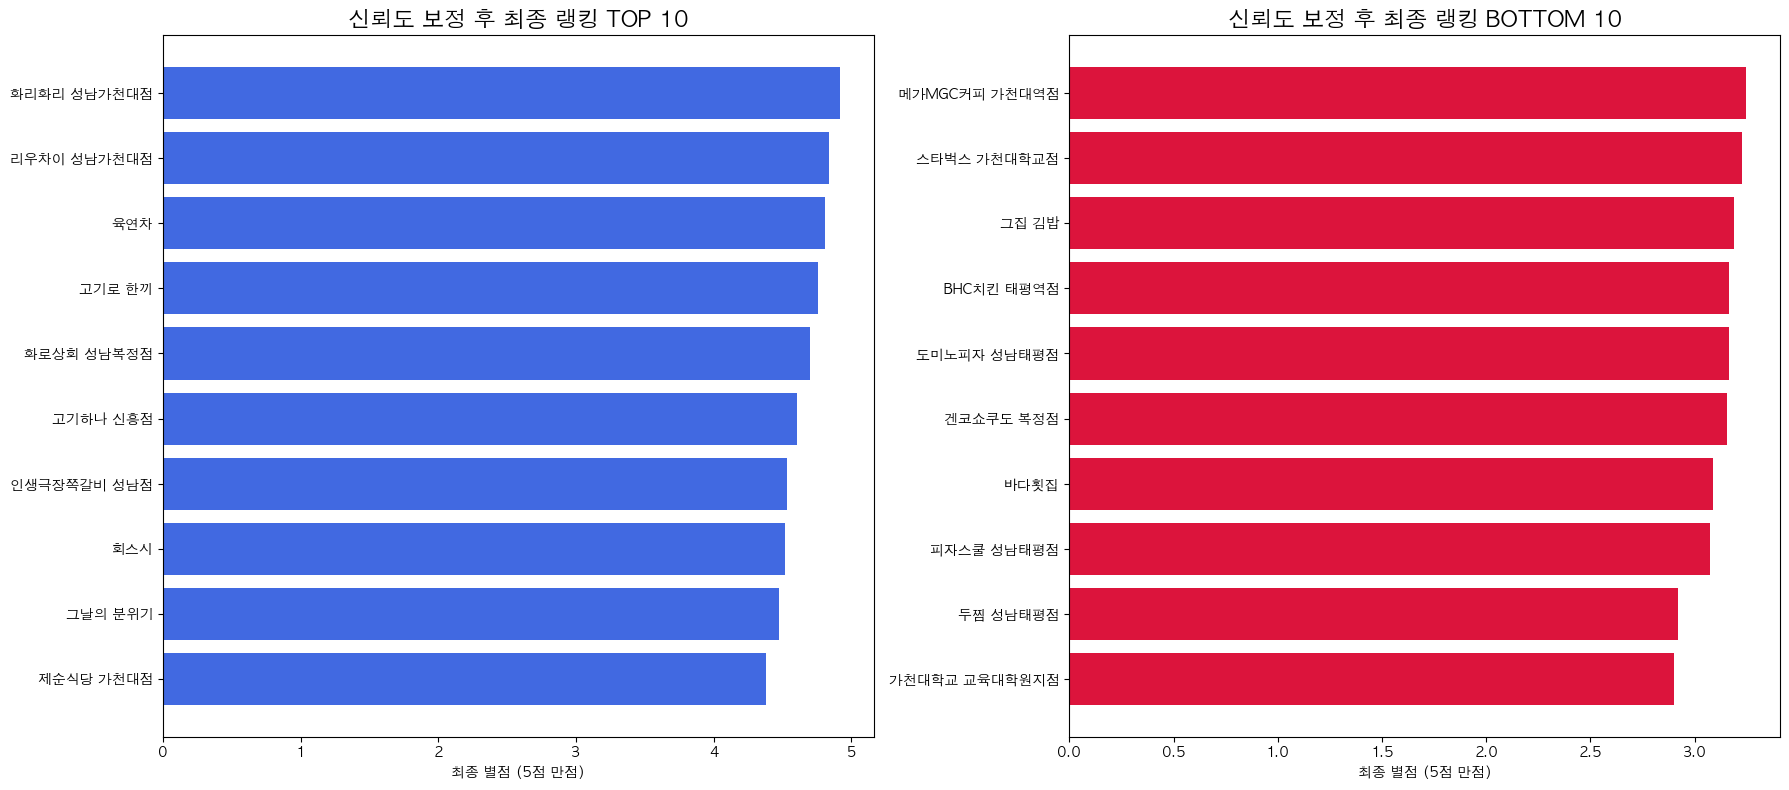

In [426]:
# 상위 10개와 하위 10개 데이터를 준비합니다.
top_10 = df.head(10).sort_values(by='Final_Rating', ascending=True)
bottom_10 = df.tail(10).sort_values(by='Final_Rating', ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(18, 8)) # 1행 2열로 그래프 2개를 나란히

# 상위 10개 막대그래프
ax[0].barh(top_10['Restaurant'], top_10['Final_Rating'], color='royalblue')
ax[0].set_title('신뢰도 보정 후 최종 랭킹 TOP 10', size=16)
ax[0].set_xlabel('최종 별점 (5점 만점)')

# 하위 10개 막대그래프
ax[1].barh(bottom_10['Restaurant'], bottom_10['Final_Rating'], color='crimson')
ax[1].set_title('신뢰도 보정 후 최종 랭킹 BOTTOM 10', size=16)
ax[1].set_xlabel('최종 별점 (5점 만점)')

plt.tight_layout() # 그래프 간격 자동 조절
plt.show()